In [670]:
import torch 
from torch import nn
from torch import FloatTensor
from torch.autograd import Variable
from torch import optim

from numpy.linalg import matrix_rank
from sklearn.datasets import make_spd_matrix
import os
from networkx import nx
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report

from random import shuffle

import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
import SPD
import dataset_tools as dt

# Что хотим тут делать: 

Краткое описание задачи. Имеем [статью](https://aaai.org/ocs/index.php/AAAI/AAAI17/paper/download/14825/14321), в которой описан метод, который позволяет работать с положительными симметричными матрицами, а именно отображать их в матрица меньшего размера (что  круто). Сама статья не очень сложная, поэтому попробуем с помошью идей из нее решить некоторую другую задачу.

Например, известно, что кроме матрицы смежностей для графов определяют еще [матрицу Лапласа](https://en.wikipedia.org/wiki/Laplacian_matrix), которая в качестве одного из своих свойств является неотрицательно определенной 

## Маломерное представление для матриц смежности

В качестве первой задачи попробуем сделать некоторое подобие энкодера для графов, у которого в качестве слоев возьмем слои из статьи выше. Эксперименты будем проводить на [датасете](https://figshare.com/articles/MUTAG_and_ENZYMES_DataSet/899875), в котором есть ~200  графов. Обучим самый простой энкодер всего с 4-мя слоями: по два линейных и два SymmetricallyCleanLayer из статьи. 

### Датасет из положительно определённых матриц

Сначала просто для теста сгенерим датасет из положительно определенных матриц и посмотрим на его результаты. 

In [187]:
# учим сетку, возвращаем ее и датасет
coder, dataset = SPD.run_test(n_iterations=1000)


  1%|          | 12/999 [00:01<01:24, 11.62it/s]

EPOCH: 10, TRAIN LOSS: 6.968207359313965, TEST LOSS 8.690054893493652



  2%|▏         | 22/999 [00:01<01:24, 11.55it/s]

EPOCH: 20, TRAIN LOSS: 2.341021776199341, TEST LOSS 2.6160192489624023



  3%|▎         | 32/999 [00:02<01:24, 11.44it/s]

EPOCH: 30, TRAIN LOSS: 1.4044148921966553, TEST LOSS 1.2379708290100098



  4%|▍         | 40/999 [00:03<01:25, 11.19it/s]

EPOCH: 40, TRAIN LOSS: 1.2449212074279785, TEST LOSS 1.1252540349960327



  5%|▌         | 51/999 [00:04<01:28, 10.70it/s]

EPOCH: 50, TRAIN LOSS: 1.174118995666504, TEST LOSS 1.1086227893829346



  6%|▌         | 61/999 [00:05<01:31, 10.26it/s]

EPOCH: 60, TRAIN LOSS: 1.140807032585144, TEST LOSS 1.1053504943847656



  7%|▋         | 71/999 [00:06<01:30, 10.21it/s]

EPOCH: 70, TRAIN LOSS: 1.119438648223877, TEST LOSS 1.1050883531570435



  7%|▋         | 73/999 [00:07<01:32, 10.06it/s]
Exception in thread Thread-17:
Traceback (most recent call last):
  File "/Users/Macbook/anaconda/envs/py35/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/Macbook/anaconda/envs/py35/lib/python3.5/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/Macbook/anaconda/envs/py35/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  8%|▊         | 82/999 [00:08<01:29, 10.23it/s]

EPOCH: 80, TRAIN LOSS: 1.097057819366455, TEST LOSS 1.1052597761154175


  9%|▉         | 90/999 [00:08<01:29, 10.19it/s]

EPOCH: 90, TRAIN LOSS: 1.0706404447555542, TEST LOSS 1.0951968431472778


 10%|█         | 101/999 [00:09<01:28, 10.16it/s]

EPOCH: 100, TRAIN LOSS: 1.0402038097381592, TEST LOSS 1.0721750259399414


 11%|█         | 111/999 [00:10<01:26, 10.22it/s]

EPOCH: 110, TRAIN LOSS: 1.0018846988677979, TEST LOSS 1.0364058017730713


 12%|█▏        | 121/999 [00:11<01:24, 10.36it/s]

EPOCH: 120, TRAIN LOSS: 0.9751952886581421, TEST LOSS 1.0089508295059204


 13%|█▎        | 131/999 [00:12<01:23, 10.42it/s]

EPOCH: 130, TRAIN LOSS: 0.9579085111618042, TEST LOSS 0.9946497082710266


 14%|█▍        | 141/999 [00:13<01:22, 10.35it/s]

EPOCH: 140, TRAIN LOSS: 0.9389818906784058, TEST LOSS 0.9835097789764404


 15%|█▌        | 151/999 [00:14<01:22, 10.34it/s]

EPOCH: 150, TRAIN LOSS: 0.9207599759101868, TEST LOSS 0.9750453233718872


 16%|█▌        | 161/999 [00:15<01:21, 10.23it/s]

EPOCH: 160, TRAIN LOSS: 0.9022831916809082, TEST LOSS 0.9627546668052673


 17%|█▋        | 171/999 [00:16<01:20, 10.24it/s]

EPOCH: 170, TRAIN LOSS: 0.8818556070327759, TEST LOSS 0.9468567967414856


 18%|█▊        | 181/999 [00:17<01:19, 10.33it/s]

EPOCH: 180, TRAIN LOSS: 0.8600527048110962, TEST LOSS 0.9284488558769226


 19%|█▉        | 191/999 [00:18<01:18, 10.35it/s]

EPOCH: 190, TRAIN LOSS: 0.8371096849441528, TEST LOSS 0.9050159454345703


 20%|██        | 201/999 [00:19<01:16, 10.42it/s]

EPOCH: 200, TRAIN LOSS: 0.8155864477157593, TEST LOSS 0.8808035850524902


 21%|██        | 211/999 [00:20<01:15, 10.48it/s]

EPOCH: 210, TRAIN LOSS: 0.7945561408996582, TEST LOSS 0.8602314591407776


 22%|██▏       | 221/999 [00:20<01:13, 10.53it/s]

EPOCH: 220, TRAIN LOSS: 0.77338045835495, TEST LOSS 0.841893196105957


 23%|██▎       | 231/999 [00:22<01:13, 10.49it/s]

EPOCH: 230, TRAIN LOSS: 0.7513979077339172, TEST LOSS 0.8237003087997437


 24%|██▍       | 242/999 [00:23<01:12, 10.41it/s]

EPOCH: 240, TRAIN LOSS: 0.7281006574630737, TEST LOSS 0.8054870963096619


 25%|██▌       | 252/999 [00:24<01:11, 10.46it/s]

EPOCH: 250, TRAIN LOSS: 0.7027376890182495, TEST LOSS 0.7831583619117737


 26%|██▌       | 260/999 [00:24<01:10, 10.43it/s]

EPOCH: 260, TRAIN LOSS: 0.6744909286499023, TEST LOSS 0.7549208998680115


 27%|██▋       | 272/999 [00:26<01:10, 10.36it/s]

EPOCH: 270, TRAIN LOSS: 0.644681453704834, TEST LOSS 0.7194063067436218


 28%|██▊       | 282/999 [00:27<01:09, 10.37it/s]

EPOCH: 280, TRAIN LOSS: 0.6157381534576416, TEST LOSS 0.6807851791381836


 29%|██▉       | 292/999 [00:28<01:07, 10.41it/s]

EPOCH: 290, TRAIN LOSS: 0.5910767316818237, TEST LOSS 0.6493476033210754


 30%|███       | 302/999 [00:28<01:06, 10.42it/s]

EPOCH: 300, TRAIN LOSS: 0.5682643055915833, TEST LOSS 0.6242988109588623


 31%|███       | 312/999 [00:29<01:05, 10.46it/s]

EPOCH: 310, TRAIN LOSS: 0.5459584593772888, TEST LOSS 0.603882908821106


 32%|███▏      | 322/999 [00:30<01:04, 10.50it/s]

EPOCH: 320, TRAIN LOSS: 0.5239473581314087, TEST LOSS 0.5831701755523682


 33%|███▎      | 332/999 [00:31<01:03, 10.52it/s]

EPOCH: 330, TRAIN LOSS: 0.5008547902107239, TEST LOSS 0.5630534887313843


 34%|███▍      | 342/999 [00:32<01:02, 10.52it/s]

EPOCH: 340, TRAIN LOSS: 0.47753703594207764, TEST LOSS 0.542799711227417


 35%|███▌      | 352/999 [00:33<01:01, 10.54it/s]

EPOCH: 350, TRAIN LOSS: 0.4532957971096039, TEST LOSS 0.5200625658035278


 36%|███▌      | 362/999 [00:34<01:00, 10.58it/s]

EPOCH: 360, TRAIN LOSS: 0.43020886182785034, TEST LOSS 0.4977532923221588


 37%|███▋      | 370/999 [00:34<00:59, 10.59it/s]

EPOCH: 370, TRAIN LOSS: 0.40932437777519226, TEST LOSS 0.47675567865371704


 38%|███▊      | 382/999 [00:36<00:58, 10.58it/s]

EPOCH: 380, TRAIN LOSS: 0.3919260799884796, TEST LOSS 0.46117103099823


 39%|███▉      | 392/999 [00:37<00:57, 10.59it/s]

EPOCH: 390, TRAIN LOSS: 0.376848042011261, TEST LOSS 0.4479031562805176


 40%|████      | 402/999 [00:37<00:56, 10.63it/s]

EPOCH: 400, TRAIN LOSS: 0.36309459805488586, TEST LOSS 0.43634364008903503


 41%|████      | 412/999 [00:38<00:55, 10.60it/s]

EPOCH: 410, TRAIN LOSS: 0.35072094202041626, TEST LOSS 0.4279869496822357


 42%|████▏     | 422/999 [00:39<00:54, 10.61it/s]

EPOCH: 420, TRAIN LOSS: 0.33966511487960815, TEST LOSS 0.4205702543258667


 43%|████▎     | 432/999 [00:40<00:53, 10.63it/s]

EPOCH: 430, TRAIN LOSS: 0.32970428466796875, TEST LOSS 0.4144282639026642


 44%|████▍     | 442/999 [00:41<00:52, 10.67it/s]

EPOCH: 440, TRAIN LOSS: 0.3210178315639496, TEST LOSS 0.40911248326301575


 45%|████▌     | 452/999 [00:42<00:51, 10.68it/s]

EPOCH: 450, TRAIN LOSS: 0.313498318195343, TEST LOSS 0.4042074978351593


 46%|████▌     | 462/999 [00:43<00:50, 10.72it/s]

EPOCH: 460, TRAIN LOSS: 0.3064330518245697, TEST LOSS 0.4002317786216736


 47%|████▋     | 472/999 [00:43<00:48, 10.76it/s]

EPOCH: 470, TRAIN LOSS: 0.30021706223487854, TEST LOSS 0.3970071077346802


 48%|████▊     | 482/999 [00:44<00:47, 10.80it/s]

EPOCH: 480, TRAIN LOSS: 0.2947506606578827, TEST LOSS 0.3945746421813965


 49%|████▉     | 492/999 [00:45<00:46, 10.82it/s]

EPOCH: 490, TRAIN LOSS: 0.290019690990448, TEST LOSS 0.39277124404907227


 50%|█████     | 500/999 [00:46<00:46, 10.84it/s]

EPOCH: 500, TRAIN LOSS: 0.28606343269348145, TEST LOSS 0.3914687931537628


 51%|█████▏    | 512/999 [00:47<00:44, 10.86it/s]

EPOCH: 510, TRAIN LOSS: 0.2828051745891571, TEST LOSS 0.3904089033603668


 52%|█████▏    | 520/999 [00:47<00:44, 10.88it/s]

EPOCH: 520, TRAIN LOSS: 0.2801343500614166, TEST LOSS 0.38960394263267517


 53%|█████▎    | 532/999 [00:48<00:42, 10.89it/s]

EPOCH: 530, TRAIN LOSS: 0.27786290645599365, TEST LOSS 0.38878029584884644


 54%|█████▍    | 542/999 [00:49<00:41, 10.91it/s]

EPOCH: 540, TRAIN LOSS: 0.27581286430358887, TEST LOSS 0.38791623711586


 55%|█████▌    | 552/999 [00:50<00:40, 10.93it/s]

EPOCH: 550, TRAIN LOSS: 0.2740107476711273, TEST LOSS 0.38689884543418884


 56%|█████▋    | 562/999 [00:51<00:40, 10.92it/s]

EPOCH: 560, TRAIN LOSS: 0.27241870760917664, TEST LOSS 0.38578611612319946


 57%|█████▋    | 572/999 [00:52<00:39, 10.93it/s]

EPOCH: 570, TRAIN LOSS: 0.27096718549728394, TEST LOSS 0.38464629650115967


 58%|█████▊    | 582/999 [00:53<00:38, 10.94it/s]

EPOCH: 580, TRAIN LOSS: 0.26960596442222595, TEST LOSS 0.3834735155105591


 59%|█████▉    | 592/999 [00:54<00:37, 10.95it/s]

EPOCH: 590, TRAIN LOSS: 0.2683123052120209, TEST LOSS 0.38238564133644104


 60%|██████    | 602/999 [00:55<00:36, 10.94it/s]

EPOCH: 600, TRAIN LOSS: 0.26707711815834045, TEST LOSS 0.3811727464199066


 61%|██████▏   | 612/999 [00:55<00:35, 10.97it/s]

EPOCH: 610, TRAIN LOSS: 0.26590651273727417, TEST LOSS 0.3799596130847931


 62%|██████▏   | 622/999 [00:56<00:34, 11.00it/s]

EPOCH: 620, TRAIN LOSS: 0.2647686004638672, TEST LOSS 0.37864622473716736


 63%|██████▎   | 632/999 [00:57<00:33, 11.02it/s]

EPOCH: 630, TRAIN LOSS: 0.26363107562065125, TEST LOSS 0.37736016511917114


 64%|██████▍   | 642/999 [00:58<00:32, 11.03it/s]

EPOCH: 640, TRAIN LOSS: 0.26247379183769226, TEST LOSS 0.37601345777511597


 65%|██████▌   | 652/999 [00:58<00:31, 11.06it/s]

EPOCH: 650, TRAIN LOSS: 0.2612477242946625, TEST LOSS 0.374494343996048


 66%|██████▋   | 662/999 [00:59<00:30, 11.08it/s]

EPOCH: 660, TRAIN LOSS: 0.2600168287754059, TEST LOSS 0.37287259101867676


 67%|██████▋   | 670/999 [01:00<00:29, 11.10it/s]

EPOCH: 670, TRAIN LOSS: 0.25879156589508057, TEST LOSS 0.3712191581726074


 68%|██████▊   | 682/999 [01:01<00:28, 11.11it/s]

EPOCH: 680, TRAIN LOSS: 0.25753113627433777, TEST LOSS 0.3695200979709625


 69%|██████▉   | 692/999 [01:02<00:27, 11.13it/s]

EPOCH: 690, TRAIN LOSS: 0.25619906187057495, TEST LOSS 0.3678280711174011


 70%|███████   | 702/999 [01:03<00:26, 11.13it/s]

EPOCH: 700, TRAIN LOSS: 0.25483667850494385, TEST LOSS 0.366073340177536


 71%|███████▏  | 712/999 [01:04<00:25, 11.12it/s]

EPOCH: 710, TRAIN LOSS: 0.2533820867538452, TEST LOSS 0.3641358017921448


 72%|███████▏  | 721/999 [01:04<00:25, 11.10it/s]

EPOCH: 720, TRAIN LOSS: 0.25186705589294434, TEST LOSS 0.3622240424156189


 73%|███████▎  | 731/999 [01:05<00:24, 11.10it/s]

EPOCH: 730, TRAIN LOSS: 0.25027212500572205, TEST LOSS 0.36020535230636597


 74%|███████▍  | 741/999 [01:06<00:23, 11.09it/s]

EPOCH: 740, TRAIN LOSS: 0.2486053705215454, TEST LOSS 0.3577384948730469


 75%|███████▌  | 751/999 [01:07<00:22, 11.07it/s]

EPOCH: 750, TRAIN LOSS: 0.24686041474342346, TEST LOSS 0.3550771474838257


 76%|███████▌  | 761/999 [01:08<00:21, 11.07it/s]

EPOCH: 760, TRAIN LOSS: 0.24501803517341614, TEST LOSS 0.3521961271762848


 77%|███████▋  | 771/999 [01:09<00:20, 11.05it/s]

EPOCH: 770, TRAIN LOSS: 0.24306116998195648, TEST LOSS 0.34909093379974365


 78%|███████▊  | 781/999 [01:10<00:19, 11.03it/s]

EPOCH: 780, TRAIN LOSS: 0.24097806215286255, TEST LOSS 0.3455047607421875


 79%|███████▉  | 792/999 [01:12<00:18, 10.99it/s]

EPOCH: 790, TRAIN LOSS: 0.23875373601913452, TEST LOSS 0.3413948118686676


 80%|████████  | 801/999 [01:12<00:18, 10.98it/s]

EPOCH: 800, TRAIN LOSS: 0.23637869954109192, TEST LOSS 0.3368360698223114


 81%|████████  | 811/999 [01:13<00:17, 10.97it/s]

EPOCH: 810, TRAIN LOSS: 0.23384152352809906, TEST LOSS 0.3317544162273407


 82%|████████▏ | 821/999 [01:14<00:16, 10.96it/s]

EPOCH: 820, TRAIN LOSS: 0.23115096986293793, TEST LOSS 0.3262110650539398


 83%|████████▎ | 832/999 [01:16<00:15, 10.93it/s]

EPOCH: 830, TRAIN LOSS: 0.22831961512565613, TEST LOSS 0.3201711177825928


 84%|████████▍ | 841/999 [01:17<00:14, 10.91it/s]

EPOCH: 840, TRAIN LOSS: 0.22535930573940277, TEST LOSS 0.3135351538658142


 85%|████████▌ | 851/999 [01:17<00:13, 10.92it/s]

EPOCH: 850, TRAIN LOSS: 0.22225700318813324, TEST LOSS 0.30645814538002014


 86%|████████▌ | 861/999 [01:18<00:12, 10.90it/s]

EPOCH: 860, TRAIN LOSS: 0.2190544307231903, TEST LOSS 0.2989732325077057


 87%|████████▋ | 872/999 [01:20<00:11, 10.89it/s]

EPOCH: 870, TRAIN LOSS: 0.21580001711845398, TEST LOSS 0.29105526208877563


 88%|████████▊ | 881/999 [01:21<00:10, 10.86it/s]

EPOCH: 880, TRAIN LOSS: 0.21252332627773285, TEST LOSS 0.2828589081764221


 89%|████████▉ | 891/999 [01:22<00:09, 10.86it/s]

EPOCH: 890, TRAIN LOSS: 0.20925837755203247, TEST LOSS 0.274495393037796


 90%|█████████ | 900/999 [01:23<00:09, 10.84it/s]

EPOCH: 900, TRAIN LOSS: 0.20605264604091644, TEST LOSS 0.26626259088516235


 91%|█████████ | 911/999 [01:24<00:08, 10.83it/s]

EPOCH: 910, TRAIN LOSS: 0.20291344821453094, TEST LOSS 0.25824427604675293


 92%|█████████▏| 921/999 [01:25<00:07, 10.82it/s]

EPOCH: 920, TRAIN LOSS: 0.19982409477233887, TEST LOSS 0.25048592686653137


 93%|█████████▎| 932/999 [01:26<00:06, 10.80it/s]

EPOCH: 930, TRAIN LOSS: 0.19680476188659668, TEST LOSS 0.24297714233398438


 94%|█████████▍| 942/999 [01:27<00:05, 10.78it/s]

EPOCH: 940, TRAIN LOSS: 0.19389823079109192, TEST LOSS 0.23559673130512238


 95%|█████████▌| 952/999 [01:28<00:04, 10.78it/s]

EPOCH: 950, TRAIN LOSS: 0.1911197006702423, TEST LOSS 0.22859683632850647


 96%|█████████▋| 962/999 [01:29<00:03, 10.78it/s]

EPOCH: 960, TRAIN LOSS: 0.1884855180978775, TEST LOSS 0.22202636301517487


 97%|█████████▋| 971/999 [01:30<00:02, 10.77it/s]

EPOCH: 970, TRAIN LOSS: 0.18602560460567474, TEST LOSS 0.21582242846488953


 98%|█████████▊| 981/999 [01:31<00:01, 10.74it/s]

EPOCH: 980, TRAIN LOSS: 0.18375475704669952, TEST LOSS 0.20998935401439667


 99%|█████████▉| 991/999 [01:32<00:00, 10.73it/s]

EPOCH: 990, TRAIN LOSS: 0.18164803087711334, TEST LOSS 0.2044777125120163


100%|██████████| 999/999 [01:33<00:00, 10.72it/s]


In [190]:
print("Результат применения нашей модели к произвольной матрице\n", coder(dataset)[0])
print("Сама матрица\n", dataset[0])

Результат применения нашей модели к произвольной матрице
 Variable containing:
 1.1597 -1.2545  0.2238 -1.3226 -0.8728 -0.5074
-1.2545  1.8764 -0.3922  1.6513  0.9479  0.4915
 0.2238 -0.3922  0.3590 -0.5085 -0.3040 -0.0251
-1.3226  1.6513 -0.5085  2.5638  1.1053  0.3887
-0.8728  0.9479 -0.3040  1.1053  1.4248  0.0865
-0.5074  0.4915 -0.0251  0.3887  0.0865  0.3594
[torch.FloatTensor of size 6x6]

Сама матрица
 Variable containing:
 1.6538 -1.6044  0.2423 -1.5757 -0.8835 -0.0873
-1.6044  2.3821 -0.3803  2.0151  1.1325  0.0097
 0.2423 -0.3803  0.3766 -0.4845 -0.2825 -0.0868
-1.5757  2.0151 -0.4845  2.5606  1.0514  0.2524
-0.8835  1.1325 -0.2825  1.0514  1.3400  0.0003
-0.0873  0.0097 -0.0868  0.2524  0.0003  0.3175
[torch.FloatTensor of size 6x6]



Работает вполне неплохо, что и ожидалось 

### Mutag датасет

Тут пробуем нашу модель на графовом датасете. Для каждого графа считаем его матрицу лапласа и кладем ее в выборку, потом на этом деле снова начинаем учить сетку. 

In [193]:
coder, dataset = SPD.run_test_mutag(n_iterations=500)

  2%|▏         | 11/499 [00:02<01:28,  5.49it/s]

EPOCH: 10, TRAIN LOSS: 0.19712954759597778, TEST LOSS 0.14197520911693573


  4%|▍         | 21/499 [00:03<01:29,  5.32it/s]

EPOCH: 20, TRAIN LOSS: 0.14037972688674927, TEST LOSS 0.12351789325475693


  6%|▌         | 30/499 [00:05<01:27,  5.35it/s]

EPOCH: 30, TRAIN LOSS: 0.127322718501091, TEST LOSS 0.11167646944522858


  8%|▊         | 41/499 [00:07<01:27,  5.25it/s]

EPOCH: 40, TRAIN LOSS: 0.11849711835384369, TEST LOSS 0.1044565960764885


 10%|█         | 51/499 [00:09<01:24,  5.27it/s]

EPOCH: 50, TRAIN LOSS: 0.11534447222948074, TEST LOSS 0.10198447108268738


 12%|█▏        | 61/499 [00:11<01:23,  5.28it/s]

EPOCH: 60, TRAIN LOSS: 0.11363948881626129, TEST LOSS 0.10063354671001434


 14%|█▍        | 71/499 [00:13<01:20,  5.33it/s]

EPOCH: 70, TRAIN LOSS: 0.11213558167219162, TEST LOSS 0.09911224246025085


 16%|█▌        | 81/499 [00:15<01:18,  5.35it/s]

EPOCH: 80, TRAIN LOSS: 0.11067698895931244, TEST LOSS 0.09766237437725067


 18%|█▊        | 91/499 [00:17<01:16,  5.35it/s]

EPOCH: 90, TRAIN LOSS: 0.10889769345521927, TEST LOSS 0.0962556004524231


 20%|██        | 101/499 [00:18<01:14,  5.36it/s]

EPOCH: 100, TRAIN LOSS: 0.10659370571374893, TEST LOSS 0.09432914108037949


 22%|██▏       | 111/499 [00:20<01:12,  5.37it/s]

EPOCH: 110, TRAIN LOSS: 0.10393054038286209, TEST LOSS 0.0922497883439064


 24%|██▍       | 121/499 [00:22<01:10,  5.39it/s]

EPOCH: 120, TRAIN LOSS: 0.10133963823318481, TEST LOSS 0.08909841626882553


 26%|██▋       | 131/499 [00:24<01:07,  5.41it/s]

EPOCH: 130, TRAIN LOSS: 0.09909091144800186, TEST LOSS 0.08707249909639359


 28%|██▊       | 141/499 [00:26<01:06,  5.42it/s]

EPOCH: 140, TRAIN LOSS: 0.0968422219157219, TEST LOSS 0.0854298546910286


 30%|███       | 151/499 [00:27<01:04,  5.43it/s]

EPOCH: 150, TRAIN LOSS: 0.09379082173109055, TEST LOSS 0.0823960155248642


 32%|███▏      | 161/499 [00:29<01:02,  5.45it/s]

EPOCH: 160, TRAIN LOSS: 0.0889708399772644, TEST LOSS 0.07758042961359024


 34%|███▍      | 171/499 [00:31<01:00,  5.45it/s]

EPOCH: 170, TRAIN LOSS: 0.0828920304775238, TEST LOSS 0.07190632075071335


 36%|███▋      | 181/499 [00:33<00:58,  5.42it/s]

EPOCH: 180, TRAIN LOSS: 0.07788261026144028, TEST LOSS 0.06751977652311325


 38%|███▊      | 191/499 [00:35<00:56,  5.44it/s]

EPOCH: 190, TRAIN LOSS: 0.07396620512008667, TEST LOSS 0.06443893909454346


 40%|████      | 201/499 [00:36<00:54,  5.44it/s]

EPOCH: 200, TRAIN LOSS: 0.0702691301703453, TEST LOSS 0.06176358088850975


 42%|████▏     | 211/499 [00:38<00:53,  5.43it/s]

EPOCH: 210, TRAIN LOSS: 0.06590130925178528, TEST LOSS 0.05924762412905693


 44%|████▍     | 220/499 [00:41<00:52,  5.29it/s]

EPOCH: 220, TRAIN LOSS: 0.0626073107123375, TEST LOSS 0.05728299170732498


 46%|████▋     | 231/499 [00:43<00:50,  5.27it/s]

EPOCH: 230, TRAIN LOSS: 0.06048348546028137, TEST LOSS 0.055967047810554504


 48%|████▊     | 240/499 [00:45<00:49,  5.25it/s]

EPOCH: 240, TRAIN LOSS: 0.0583941787481308, TEST LOSS 0.05473392456769943


 50%|█████     | 250/499 [00:47<00:47,  5.24it/s]

EPOCH: 250, TRAIN LOSS: 0.05624337121844292, TEST LOSS 0.05337804555892944


 52%|█████▏    | 261/499 [00:50<00:45,  5.22it/s]

EPOCH: 260, TRAIN LOSS: 0.053436532616615295, TEST LOSS 0.051445819437503815


 54%|█████▍    | 270/499 [00:52<00:44,  5.19it/s]

EPOCH: 270, TRAIN LOSS: 0.051017891615629196, TEST LOSS 0.04970152676105499


 56%|█████▌    | 280/499 [00:54<00:42,  5.16it/s]

EPOCH: 280, TRAIN LOSS: 0.04926129803061485, TEST LOSS 0.048522159457206726


 58%|█████▊    | 291/499 [00:56<00:40,  5.16it/s]

EPOCH: 290, TRAIN LOSS: 0.04794570803642273, TEST LOSS 0.047715023159980774


 60%|██████    | 301/499 [00:58<00:38,  5.16it/s]

EPOCH: 300, TRAIN LOSS: 0.046789806336164474, TEST LOSS 0.04697312042117119


 62%|██████▏   | 311/499 [01:00<00:36,  5.11it/s]

EPOCH: 310, TRAIN LOSS: 0.04569118842482567, TEST LOSS 0.046245116740465164


 64%|██████▍   | 321/499 [01:02<00:34,  5.12it/s]

EPOCH: 320, TRAIN LOSS: 0.04464269056916237, TEST LOSS 0.045528557151556015


 66%|██████▋   | 331/499 [01:04<00:32,  5.14it/s]

EPOCH: 330, TRAIN LOSS: 0.043658193200826645, TEST LOSS 0.0448172353208065


 68%|██████▊   | 341/499 [01:06<00:30,  5.15it/s]

EPOCH: 340, TRAIN LOSS: 0.04271497204899788, TEST LOSS 0.04410538449883461


 70%|███████   | 351/499 [01:07<00:28,  5.16it/s]

EPOCH: 350, TRAIN LOSS: 0.04161064699292183, TEST LOSS 0.04310958832502365


 72%|███████▏  | 361/499 [01:09<00:26,  5.17it/s]

EPOCH: 360, TRAIN LOSS: 0.04047416150569916, TEST LOSS 0.04213237389922142


 74%|███████▍  | 371/499 [01:11<00:24,  5.18it/s]

EPOCH: 370, TRAIN LOSS: 0.03930344432592392, TEST LOSS 0.04111156240105629


 76%|███████▋  | 381/499 [01:13<00:22,  5.20it/s]

EPOCH: 380, TRAIN LOSS: 0.0379781648516655, TEST LOSS 0.039856504648923874


 78%|███████▊  | 391/499 [01:15<00:20,  5.21it/s]

EPOCH: 390, TRAIN LOSS: 0.03662174195051193, TEST LOSS 0.03844829648733139


 80%|████████  | 400/499 [01:16<00:19,  5.20it/s]

EPOCH: 400, TRAIN LOSS: 0.034548625349998474, TEST LOSS 0.03631008788943291


 82%|████████▏ | 411/499 [01:19<00:16,  5.20it/s]

EPOCH: 410, TRAIN LOSS: 0.032528914511203766, TEST LOSS 0.034469470381736755


 84%|████████▍ | 421/499 [01:20<00:14,  5.21it/s]

EPOCH: 420, TRAIN LOSS: 0.030917072668671608, TEST LOSS 0.03305266797542572


 86%|████████▋ | 431/499 [01:22<00:13,  5.21it/s]

EPOCH: 430, TRAIN LOSS: 0.02959536574780941, TEST LOSS 0.03154238313436508


 88%|████████▊ | 441/499 [01:24<00:11,  5.22it/s]

EPOCH: 440, TRAIN LOSS: 0.028693348169326782, TEST LOSS 0.03057944029569626


 90%|█████████ | 451/499 [01:26<00:09,  5.23it/s]

EPOCH: 450, TRAIN LOSS: 0.028074275702238083, TEST LOSS 0.029863033443689346


 92%|█████████▏| 461/499 [01:28<00:07,  5.24it/s]

EPOCH: 460, TRAIN LOSS: 0.027620680630207062, TEST LOSS 0.02927342988550663


 94%|█████████▍| 470/499 [01:29<00:05,  5.25it/s]

EPOCH: 470, TRAIN LOSS: 0.027228673920035362, TEST LOSS 0.02875402756035328


 96%|█████████▋| 481/499 [01:31<00:03,  5.26it/s]

EPOCH: 480, TRAIN LOSS: 0.026817919686436653, TEST LOSS 0.02820870466530323


 98%|█████████▊| 491/499 [01:33<00:01,  5.27it/s]

EPOCH: 490, TRAIN LOSS: 0.026432575657963753, TEST LOSS 0.027644818648695946


100%|██████████| 499/499 [01:34<00:00,  5.28it/s]


In [197]:
print("Результат применения нашей модели к матрице построенной по графу\n", coder(dataset)[9].round())
print("Сама матрица\n", dataset[9])

Результат применения нашей модели к матрице построенной по графу
 Variable containing:
 0  1 -0  0 -0  0
 1 -0  1  0  0 -0
-0  1 -0  0  0  1
 0  0  0 -0 -0  0
-0  0  0 -0 -0  1
 0 -0  1  0  1  0
[torch.FloatTensor of size 6x6]

Сама матрица
 Variable containing:
 0  1  0  0  0  0
 1  0  1  0  0  0
 0  1  0  0  0  1
 0  0  0  0  0  0
 0  0  0  0  0  1
 0  0  1  0  1  0
[torch.FloatTensor of size 6x6]



Отрабатывает тоже вполне неплохо. Пробовал изначально сворачивать матрицу лапласа, которую считали для графа, но качество получилось плохим. Поэтому сейчас сетка работает сразу на матрицах смежностей, не особо задумываясь о том, что она может быть не положительно определенной, но блоки в сети оставляеем те же. 

Отрисуем пару получившихся графов. 

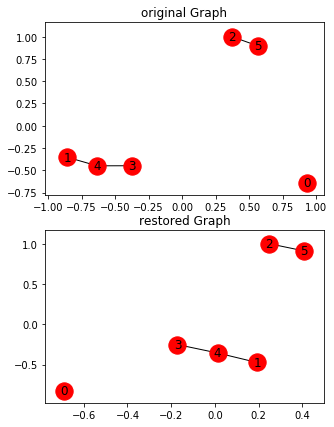

In [241]:
dt.draw_graphs(10, dataset, coder)

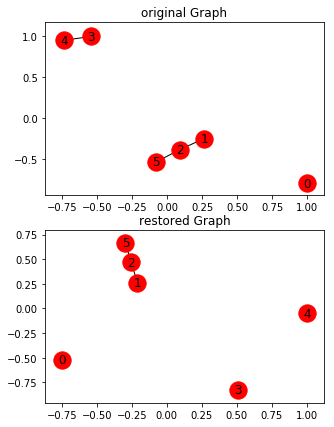

In [246]:
dt.draw_graphs(15, dataset, coder)

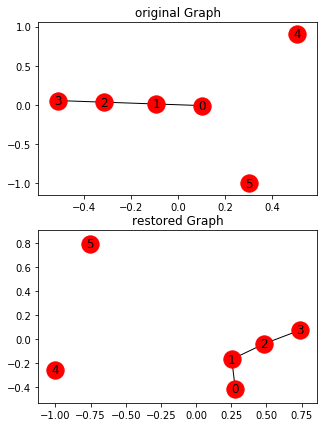

In [245]:
dt.draw_graphs(100, dataset, coder)

In [318]:
# свернем пару графов и посмотрим на их эмбеддинги 
A = coder.encoder(dataset[100].unsqueeze(0))
B = coder.encoder(dataset[4].unsqueeze(0))

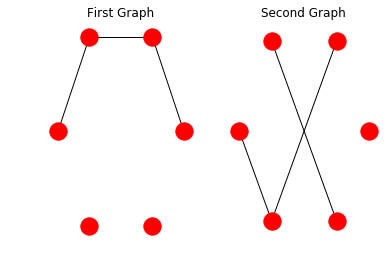

In [343]:
fig, ax = plt.subplots(ncols=2, nrows=1)
dt.draw_graph(coder.decoder(A).round(), ax=ax[0])
ax[0].set_title("First Graph")
dt.draw_graph(coder.decoder(B).round(), ax=ax[1])
ax[1].set_title("Second Graph")
plt.legend()

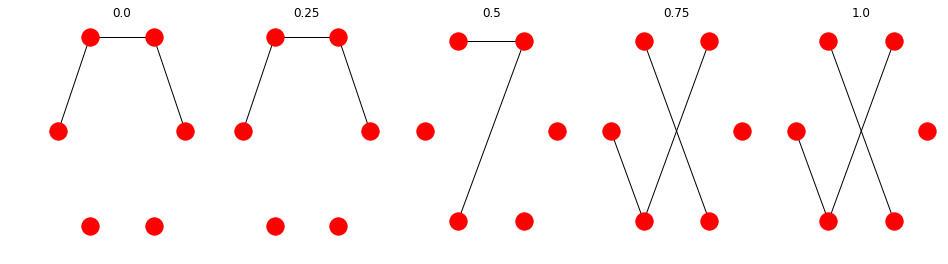

In [375]:
n_points = 5
fig = plt.figure(figsize=(16, 4))
for i, t in enumerate(np.linspace(0, 1, n_points)):
    C_t = A - (A-B)*t
    GC_t = coder.decoder(C_t).round()
    ax = fig.add_subplot(1,n_points,i+1)
    dt.draw_graph(GC_t, ax)
    ax.set_title(round(t, 2))
    ax.plot()

Reading graphs ...
---:  mutag_1.graphml
---:  mutag_2.graphml
---:  mutag_3.graphml
---:  mutag_4.graphml
---:  mutag_5.graphml
---:  mutag_6.graphml
---:  mutag_7.graphml
---:  mutag_8.graphml
---:  mutag_9.graphml
---:  mutag_10.graphml
---:  mutag_11.graphml
---:  mutag_12.graphml
---:  mutag_13.graphml
---:  mutag_14.graphml
---:  mutag_15.graphml
---:  mutag_16.graphml
---:  mutag_17.graphml
---:  mutag_18.graphml
---:  mutag_19.graphml
---:  mutag_20.graphml
---:  mutag_21.graphml
---:  mutag_22.graphml
---:  mutag_23.graphml
---:  mutag_24.graphml
---:  mutag_25.graphml
---:  mutag_26.graphml
---:  mutag_27.graphml
---:  mutag_28.graphml
---:  mutag_29.graphml
---:  mutag_30.graphml
---:  mutag_31.graphml
---:  mutag_32.graphml
---:  mutag_33.graphml
---:  mutag_34.graphml
---:  mutag_35.graphml
---:  mutag_36.graphml
---:  mutag_37.graphml
---:  mutag_38.graphml
---:  mutag_39.graphml
---:  mutag_40.graphml
---:  mutag_41.graphml
---:  mutag_42.graphml
---:  mutag_43.graphml
-

  0%|          | 0/4999 [00:00<?, ?it/s]

mutag_45.graphml
---:  mutag_46.graphml
---:  mutag_47.graphml
---:  mutag_48.graphml
---:  mutag_49.graphml
---:  mutag_50.graphml
---:  mutag_51.graphml
---:  mutag_52.graphml
---:  mutag_53.graphml
---:  mutag_54.graphml
---:  mutag_55.graphml
---:  mutag_56.graphml
---:  mutag_57.graphml
---:  mutag_58.graphml
---:  mutag_59.graphml
---:  mutag_60.graphml
---:  mutag_61.graphml
---:  mutag_62.graphml
---:  mutag_63.graphml
---:  mutag_64.graphml
---:  mutag_65.graphml
---:  mutag_66.graphml
---:  mutag_67.graphml
---:  mutag_68.graphml
---:  mutag_69.graphml
---:  mutag_70.graphml
---:  mutag_71.graphml
---:  mutag_72.graphml
---:  mutag_73.graphml
---:  mutag_74.graphml
---:  mutag_75.graphml
---:  mutag_76.graphml
---:  mutag_77.graphml
---:  mutag_78.graphml
---:  mutag_79.graphml
---:  mutag_80.graphml
---:  mutag_81.graphml
---:  mutag_82.graphml
---:  mutag_83.graphml
---:  mutag_84.graphml
---:  mutag_85.graphml
---:  mutag_86.graphml
---:  mutag_87.graphml
---:  mutag_88.gr

/Users/Macbook/Desktop/MIPT/Optimization_course/SPD_reduce/SPD.py:420: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/Macbook/Desktop/MIPT/Optimization_course/SPD_reduce/SPD.py:415: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  1%|          | 35/4999 [00:00<00:28, 171.35it/s]

EPOCH: 10, TRAIN LOSS: 12025.7685546875, TEST LOSS 194.8460693359375
EPOCH: 20, TRAIN LOSS: 10893.1064453125, TEST LOSS 168.12779235839844
EPOCH: 30, TRAIN LOSS: 9602.6767578125, TEST LOSS 137.49652099609375
EPOCH: 40, TRAIN LOSS: 8409.6689453125, TEST LOSS 117.1836929321289


  1%|▏         | 71/4999 [00:00<00:28, 173.36it/s]

EPOCH: 50, TRAIN LOSS: 7694.2724609375, TEST LOSS 107.41378784179688
EPOCH: 60, TRAIN LOSS: 7388.806640625, TEST LOSS 114.82440948486328
EPOCH: 70, TRAIN LOSS: 7180.66650390625, TEST LOSS 117.98662567138672
EPOCH: 80, TRAIN LOSS: 7044.8994140625, TEST LOSS 118.58479309082031


  2%|▏         | 123/4999 [00:00<00:28, 170.08it/s]

EPOCH: 90, TRAIN LOSS: 6901.1337890625, TEST LOSS 100.3840103149414
EPOCH: 100, TRAIN LOSS: 6828.9716796875, TEST LOSS 96.12066650390625
EPOCH: 110, TRAIN LOSS: 6858.3212890625, TEST LOSS 95.39215087890625
EPOCH: 120, TRAIN LOSS: 6664.2431640625, TEST LOSS 96.34513854980469


  3%|▎         | 161/4999 [00:00<00:27, 173.17it/s]

EPOCH: 130, TRAIN LOSS: 6567.32177734375, TEST LOSS 98.2985610961914
EPOCH: 140, TRAIN LOSS: 6487.99462890625, TEST LOSS 85.55653381347656
EPOCH: 150, TRAIN LOSS: 6330.880859375, TEST LOSS 89.89641571044922
EPOCH: 160, TRAIN LOSS: 6210.84814453125, TEST LOSS 93.99952697753906


  4%|▍         | 198/4999 [00:01<00:27, 174.03it/s]

EPOCH: 170, TRAIN LOSS: 6084.890625, TEST LOSS 95.74514770507812
EPOCH: 180, TRAIN LOSS: 5966.3857421875, TEST LOSS 83.70118713378906
EPOCH: 190, TRAIN LOSS: 5819.076171875, TEST LOSS 91.65496063232422
EPOCH: 200, TRAIN LOSS: 5692.30224609375, TEST LOSS 91.95552062988281


  5%|▍         | 234/4999 [00:01<00:27, 173.33it/s]

EPOCH: 210, TRAIN LOSS: 5588.3046875, TEST LOSS 81.29997253417969
EPOCH: 220, TRAIN LOSS: 5398.16650390625, TEST LOSS 81.06413269042969
EPOCH: 230, TRAIN LOSS: 5372.1181640625, TEST LOSS 96.39537048339844
EPOCH: 240, TRAIN LOSS: 5184.00146484375, TEST LOSS 84.15594482421875


  5%|▌         | 271/4999 [00:01<00:27, 172.74it/s]

EPOCH: 250, TRAIN LOSS: 5062.4677734375, TEST LOSS 96.05667114257812
EPOCH: 260, TRAIN LOSS: 5002.328125, TEST LOSS 80.81526184082031
EPOCH: 270, TRAIN LOSS: 4920.01611328125, TEST LOSS 89.84008026123047
EPOCH: 280, TRAIN LOSS: 4810.1015625, TEST LOSS 92.42985534667969


  6%|▌         | 308/4999 [00:01<00:27, 167.76it/s]

EPOCH: 290, TRAIN LOSS: 4788.240234375, TEST LOSS 111.89091491699219
EPOCH: 300, TRAIN LOSS: 4697.6318359375, TEST LOSS 95.19720458984375
EPOCH: 310, TRAIN LOSS: 4562.81689453125, TEST LOSS 81.44309997558594


  7%|▋         | 339/4999 [00:02<00:29, 159.14it/s]

EPOCH: 320, TRAIN LOSS: 4516.25, TEST LOSS 82.58027648925781
EPOCH: 330, TRAIN LOSS: 4613.041015625, TEST LOSS 92.15776062011719


  7%|▋         | 354/4999 [00:02<00:29, 158.36it/s]

EPOCH: 340, TRAIN LOSS: 4444.650390625, TEST LOSS 78.31021881103516
EPOCH: 350, TRAIN LOSS: 4413.224609375, TEST LOSS 86.90116882324219
EPOCH: 360, TRAIN LOSS: 4412.8671875, TEST LOSS 75.87663269042969


  8%|▊         | 381/4999 [00:02<00:29, 154.08it/s]

EPOCH: 370, TRAIN LOSS: 4365.0185546875, TEST LOSS 86.58741760253906
EPOCH: 380, TRAIN LOSS: 4198.580078125, TEST LOSS 85.86817169189453
EPOCH: 390, TRAIN LOSS: 4244.111328125, TEST LOSS 92.91175842285156


  8%|▊         | 407/4999 [00:02<00:30, 150.04it/s]

EPOCH: 400, TRAIN LOSS: 4088.23828125, TEST LOSS 78.73849487304688
EPOCH: 410, TRAIN LOSS: 4190.05908203125, TEST LOSS 83.45155334472656


  9%|▉         | 443/4999 [00:03<00:31, 144.45it/s]

EPOCH: 420, TRAIN LOSS: 3961.6318359375, TEST LOSS 77.25059509277344
EPOCH: 430, TRAIN LOSS: 4036.84130859375, TEST LOSS 82.53994750976562
EPOCH: 440, TRAIN LOSS: 3950.26171875, TEST LOSS 74.07083892822266


  9%|▉         | 468/4999 [00:03<00:31, 142.42it/s]

EPOCH: 450, TRAIN LOSS: 3878.01611328125, TEST LOSS 77.6578369140625
EPOCH: 460, TRAIN LOSS: 3837.8046875, TEST LOSS 84.20787048339844
EPOCH: 470, TRAIN LOSS: 3884.576904296875, TEST LOSS 72.25751495361328


 10%|▉         | 492/4999 [00:03<00:32, 140.52it/s]

EPOCH: 480, TRAIN LOSS: 3820.401123046875, TEST LOSS 75.83910369873047
EPOCH: 490, TRAIN LOSS: 3884.9560546875, TEST LOSS 68.76390838623047
EPOCH: 500, TRAIN LOSS: 3792.28076171875, TEST LOSS 72.09223937988281


 10%|█         | 523/4999 [00:03<00:31, 141.07it/s]

EPOCH: 510, TRAIN LOSS: 3775.084716796875, TEST LOSS 66.59706115722656
EPOCH: 520, TRAIN LOSS: 3722.83251953125, TEST LOSS 83.16352844238281
EPOCH: 530, TRAIN LOSS: 3656.442626953125, TEST LOSS 66.83773803710938
EPOCH: 540, TRAIN LOSS: 3617.1884765625, TEST LOSS

 11%|█▏        | 569/4999 [00:04<00:31, 140.29it/s]

 66.8174819946289
EPOCH: 550, TRAIN LOSS: 3711.983154296875, TEST LOSS 71.2048568725586
EPOCH: 560, TRAIN LOSS: 3656.72998046875, TEST LOSS 66.71329498291016
EPOCH: 570, TRAIN LOSS: 3550.33056640625, TEST LOSS 83.2120361328125


 12%|█▏        | 594/4999 [00:04<00:31, 138.28it/s]

EPOCH: 580, TRAIN LOSS: 3586.3203125, TEST LOSS 77.603759765625
EPOCH: 590, TRAIN LOSS: 3551.81640625, TEST LOSS 69.16986083984375
EPOCH: 600, TRAIN LOSS: 3593.026611328125, TEST LOSS 76.73757934570312


 13%|█▎        | 629/4999 [00:04<00:31, 139.75it/s]

EPOCH: 610, TRAIN LOSS: 3493.11083984375, TEST LOSS 89.3577880859375
EPOCH: 620, TRAIN LOSS: 3517.9677734375, TEST LOSS 58.01588821411133
EPOCH: 630, TRAIN LOSS: 3412.65185546875, TEST LOSS 74.90330505371094
EPOCH: 640, TRAIN LOSS: 3455.36572265625, TEST LOSS 64.90219116210938


 13%|█▎        | 665/4999 [00:04<00:30, 140.96it/s]

EPOCH: 650, TRAIN LOSS: 3474.36328125, TEST LOSS 67.44979858398438
EPOCH: 660, TRAIN LOSS: 3384.404296875, TEST LOSS 71.23445892333984
EPOCH: 670, TRAIN LOSS: 3444.09765625, TEST LOSS 71.02660369873047
EPOCH: 680, TRAIN LOSS: 3329.8544921875, TEST LOSS 69.75025939941406


 14%|█▍        | 718/4999 [00:05<00:30, 142.64it/s]

EPOCH: 690, TRAIN LOSS: 3356.751708984375, TEST LOSS 69.91500854492188
EPOCH: 700, TRAIN LOSS: 3319.431884765625, TEST LOSS 89.01901245117188
EPOCH: 710, TRAIN LOSS: 3275.4580078125, TEST LOSS 71.53062438964844
EPOCH: 720, TRAIN LOSS: 3320.1064453125, TEST LOSS 74.80609130859375


 15%|█▌        | 753/4999 [00:05<00:29, 143.20it/s]

EPOCH: 730, TRAIN LOSS: 3308.431884765625, TEST LOSS 67.58133697509766
EPOCH: 740, TRAIN LOSS: 3235.91015625, TEST LOSS 62.74290466308594
EPOCH: 750, TRAIN LOSS: 3209.30615234375, TEST LOSS 74.01911926269531
EPOCH: 760, TRAIN LOSS: 3278.373046875, TEST LOSS 57.29388427734375


 16%|█▌        | 789/4999 [00:05<00:29, 144.44it/s]

EPOCH: 770, TRAIN LOSS: 3260.966796875, TEST LOSS 64.07685089111328
EPOCH: 780, TRAIN LOSS: 3217.020263671875, TEST LOSS 80.58541870117188
EPOCH: 790, TRAIN LOSS: 3063.1376953125, TEST LOSS 65.81718444824219
EPOCH: 800, TRAIN LOSS: 3233.11474609375, TEST LOSS 72.3906478881836


 17%|█▋        | 846/4999 [00:05<00:28, 146.65it/s]

EPOCH: 810, TRAIN LOSS: 3207.6513671875, TEST LOSS 56.09724426269531
EPOCH: 820, TRAIN LOSS: 3196.59814453125, TEST LOSS 59.24530792236328
EPOCH: 830, TRAIN LOSS: 3274.859619140625, TEST LOSS 57.282081604003906
EPOCH: 840, TRAIN LOSS: 3151.57666015625, TEST LOSS 73.91874694824219


 18%|█▊        | 885/4999 [00:05<00:27, 147.96it/s]

EPOCH: 850, TRAIN LOSS: 3055.0791015625, TEST LOSS 67.73583984375
EPOCH: 860, TRAIN LOSS: 3109.736083984375, TEST LOSS 70.66268920898438
EPOCH: 870, TRAIN LOSS: 3150.23193359375, TEST LOSS 53.21601867675781
EPOCH: 880, TRAIN LOSS: 3048.3857421875, TEST LOSS 77.92149353027344


 18%|█▊        | 923/4999 [00:06<00:27, 149.06it/s]

EPOCH: 890, TRAIN LOSS: 3177.87060546875, TEST LOSS 55.773433685302734
EPOCH: 900, TRAIN LOSS: 3066.2939453125, TEST LOSS 72.76176452636719
EPOCH: 910, TRAIN LOSS: 3054.53955078125, TEST LOSS 66.72488403320312
EPOCH: 920, TRAIN LOSS: 3084.76953125, TEST LOSS 58.337825775146484


 19%|█▉        | 960/4999 [00:06<00:26, 149.86it/s]

EPOCH: 930, TRAIN LOSS: 3029.522705078125, TEST LOSS 50.566925048828125
EPOCH: 940, TRAIN LOSS: 3053.6826171875, TEST LOSS 53.486454010009766
EPOCH: 950, TRAIN LOSS: 3040.95751953125, TEST LOSS 70.64351654052734
EPOCH: 960, TRAIN LOSS: 2982.65869140625, TEST LOSS 76.02529907226562


 20%|█▉        | 996/4999 [00:06<00:26, 150.51it/s]

EPOCH: 970, TRAIN LOSS: 3051.890869140625, TEST LOSS 85.64360809326172
EPOCH: 980, TRAIN LOSS: 2977.1953125, TEST LOSS 63.44834899902344
EPOCH: 990, TRAIN LOSS: 2935.55615234375, TEST LOSS 58.7186279296875
EPOCH: 1000, TRAIN LOSS: 2987.29931640625, TEST LOSS 79.14607238769531


 21%|██        | 1031/4999 [00:06<00:26, 149.64it/s]

EPOCH: 1010, TRAIN LOSS: 2938.29541015625, TEST LOSS 72.02265167236328
EPOCH: 1020, TRAIN LOSS: 2959.841796875, TEST LOSS 69.29051208496094
EPOCH: 1030, TRAIN LOSS: 2980.97802734375, TEST LOSS 71.57372283935547


 21%|██▏       | 1064/4999 [00:07<00:26, 150.00it/s]

EPOCH: 1040, TRAIN LOSS: 2889.775390625, TEST LOSS 59.285728454589844
EPOCH: 1050, TRAIN LOSS: 2956.826416015625, TEST LOSS 81.85728454589844
EPOCH: 1060, TRAIN LOSS: 2950.002685546875, TEST LOSS 49.577762603759766
EPOCH: 1070, TRAIN LOSS: 2875.78955078125, TEST LOSS 61.222904205322266


 22%|██▏       | 1098/4999 [00:07<00:25, 150.40it/s]

EPOCH: 1080, TRAIN LOSS: 2876.2431640625, TEST LOSS 70.08877563476562
EPOCH: 1090, TRAIN LOSS: 2805.68896484375, TEST LOSS 64.97931671142578
EPOCH: 1100, TRAIN LOSS: 2842.661865234375, TEST LOSS 71.17755889892578
EPOCH: 1110, TRAIN LOSS: 2856.61181640625, TEST LOSS 69.4129638671875


 23%|██▎       | 1153/4999 [00:07<00:25, 151.50it/s]

EPOCH: 1120, TRAIN LOSS: 2790.339599609375, TEST LOSS 77.78715515136719
EPOCH: 1130, TRAIN LOSS: 2823.873291015625, TEST LOSS 56.965633392333984
EPOCH: 1140, TRAIN LOSS: 2837.1318359375, TEST LOSS 58.937957763671875
EPOCH: 1150, TRAIN LOSS: 2814.826171875, TEST LOSS 54.596466064453125


 24%|██▍       | 1189/4999 [00:07<00:25, 151.91it/s]

EPOCH: 1160, TRAIN LOSS: 2807.57470703125, TEST LOSS 55.93389892578125
EPOCH: 1170, TRAIN LOSS: 2849.25634765625, TEST LOSS 68.0046157836914
EPOCH: 1180, TRAIN LOSS: 2793.771728515625, TEST LOSS 62.51194763183594
EPOCH: 1190, TRAIN LOSS: 2721.64111328125, TEST LOSS 72.43515014648438


 25%|██▍       | 1226/4999 [00:08<00:24, 152.65it/s]

EPOCH: 1200, TRAIN LOSS: 2769.234375, TEST LOSS 82.4151382446289
EPOCH: 1210, TRAIN LOSS: 2780.145263671875, TEST LOSS 67.13475036621094
EPOCH: 1220, TRAIN LOSS: 2838.96484375, TEST LOSS 64.35566711425781
EPOCH: 1230, TRAIN LOSS: 2708.16259765625, TEST LOSS 87.67457580566406


 25%|██▌       | 1262/4999 [00:08<00:24, 153.01it/s]

EPOCH: 1240, TRAIN LOSS: 2705.57080078125, TEST LOSS 54.88541030883789
EPOCH: 1250, TRAIN LOSS: 2818.457275390625, TEST LOSS 75.8180160522461
EPOCH: 1260, TRAIN LOSS: 2712.7822265625, TEST LOSS 74.4408950805664
EPOCH: 1270, TRAIN LOSS: 2736.861328125, TEST LOSS 69.08475494384766


 26%|██▌       | 1297/4999 [00:08<00:24, 153.27it/s]

EPOCH: 1280, TRAIN LOSS: 2780.311279296875, TEST LOSS 57.037662506103516
EPOCH: 1290, TRAIN LOSS: 2729.058349609375, TEST LOSS 70.69198608398438
EPOCH: 1300, TRAIN LOSS: 2740.250732421875, TEST LOSS 80.64201354980469
EPOCH: 1310, TRAIN LOSS: 2750.93359375, TEST LOSS 73.54669952392578


 27%|██▋       | 1353/4999 [00:08<00:23, 154.31it/s]

EPOCH: 1320, TRAIN LOSS: 2664.760498046875, TEST LOSS 63.194976806640625
EPOCH: 1330, TRAIN LOSS: 2662.845703125, TEST LOSS 70.92374420166016
EPOCH: 1340, TRAIN LOSS: 2604.604248046875, TEST LOSS 49.66624450683594
EPOCH: 1350, TRAIN LOSS: 2683.56982421875, TEST LOSS 66.76299285888672


 28%|██▊       | 1389/4999 [00:08<00:23, 154.42it/s]

EPOCH: 1360, TRAIN LOSS: 2644.715576171875, TEST LOSS 43.79309844970703
EPOCH: 1370, TRAIN LOSS: 2684.5654296875, TEST LOSS 53.13848114013672
EPOCH: 1380, TRAIN LOSS: 2628.61865234375, TEST LOSS 60.60378646850586
EPOCH: 1390, TRAIN LOSS: 2723.364501953125, TEST LOSS 68.39921569824219


 28%|██▊       | 1424/4999 [00:09<00:23, 154.39it/s]

EPOCH: 1400, TRAIN LOSS: 2667.638916015625, TEST LOSS 69.94725036621094
EPOCH: 1410, TRAIN LOSS: 2683.42041015625, TEST LOSS 75.67213439941406
EPOCH: 1420, TRAIN LOSS: 2595.01611328125, TEST LOSS 64.51237487792969
EPOCH: 1430, TRAIN LOSS: 2596.36865234375, TEST LOSS 46.81591796875


 29%|██▉       | 1458/4999 [00:09<00:22, 154.49it/s]

EPOCH: 1440, TRAIN LOSS: 2672.15234375, TEST LOSS 69.0604019165039
EPOCH: 1450, TRAIN LOSS: 2582.65673828125, TEST LOSS 95.16786193847656
EPOCH: 1460, TRAIN LOSS: 2585.650634765625, TEST LOSS 65.59832763671875
EPOCH: 1470, TRAIN LOSS: 2588.060546875, TEST LOSS 60.99700164794922


 30%|██▉       | 1493/4999 [00:09<00:22, 154.84it/s]

EPOCH: 1480, TRAIN LOSS: 2591.533203125, TEST LOSS 66.62162780761719
EPOCH: 1490, TRAIN LOSS: 2711.818359375, TEST LOSS 54.27493667602539
EPOCH: 1500, TRAIN LOSS: 2534.212646484375, TEST LOSS 56.11487579345703


 31%|███       | 1529/4999 [00:09<00:22, 154.36it/s]

EPOCH: 1510, TRAIN LOSS: 2570.4736328125, TEST LOSS 65.36408996582031
EPOCH: 1520, TRAIN LOSS: 2517.669189453125, TEST LOSS 54.8070068359375
EPOCH: 1530, TRAIN LOSS: 2604.7392578125, TEST LOSS 69.01535034179688
EPOCH: 1540, TRAIN LOSS: 2593.766845703125, TEST LOSS 52.87445068359375


 31%|███▏      | 1566/4999 [00:10<00:22, 154.90it/s]

EPOCH: 1550, TRAIN LOSS: 2510.48779296875, TEST LOSS 55.703941345214844
EPOCH: 1560, TRAIN LOSS: 2620.7177734375, TEST LOSS 41.364349365234375
EPOCH: 1570, TRAIN LOSS: 2534.7265625, TEST LOSS 51.28819274902344


 32%|███▏      | 1600/4999 [00:10<00:22, 154.39it/s]

EPOCH: 1580, TRAIN LOSS: 2585.599609375, TEST LOSS 58.31455993652344
EPOCH: 1590, TRAIN LOSS: 2575.40087890625, TEST LOSS 66.46778869628906
EPOCH: 1600, TRAIN LOSS: 2576.458251953125, TEST LOSS 47.03121566772461
EPOCH: 1610, TRAIN LOSS: 2604.273193359375, TEST LOSS 74.57105255126953


 33%|███▎      | 1650/4999 [00:10<00:21, 154.48it/s]

EPOCH: 1620, TRAIN LOSS: 2569.724609375, TEST LOSS 57.43207550048828
EPOCH: 1630, TRAIN LOSS: 2583.63671875, TEST LOSS 66.36903381347656
EPOCH: 1640, TRAIN LOSS: 2528.447021484375, TEST LOSS 50.43230056762695
EPOCH: 1650, TRAIN LOSS: 2532.707763671875, TEST LOSS 55.875267028808594


 34%|███▎      | 1687/4999 [00:10<00:21, 154.92it/s]

EPOCH: 1660, TRAIN LOSS: 2554.895751953125, TEST LOSS 56.77922058105469
EPOCH: 1670, TRAIN LOSS: 2501.601318359375, TEST LOSS 62.21728515625
EPOCH: 1680, TRAIN LOSS: 2464.556640625, TEST LOSS 56.25313949584961
EPOCH: 1690, TRAIN LOSS: 2453.8798828125, TEST LOSS 51.025779724121094


 34%|███▍      | 1720/4999 [00:11<00:21, 154.59it/s]

EPOCH: 1700, TRAIN LOSS: 2416.80126953125, TEST LOSS 78.55474090576172
EPOCH: 1710, TRAIN LOSS: 2496.32763671875, TEST LOSS 66.54532623291016
EPOCH: 1720, TRAIN LOSS: 2426.94091796875, TEST LOSS 65.0513687133789


 35%|███▌      | 1755/4999 [00:11<00:20, 154.88it/s]

EPOCH: 1730, TRAIN LOSS: 2424.28125, TEST LOSS 60.408546447753906
EPOCH: 1740, TRAIN LOSS: 2525.494873046875, TEST LOSS 83.38349914550781
EPOCH: 1750, TRAIN LOSS: 2506.705078125, TEST LOSS 53.913063049316406
EPOCH: 1760, TRAIN LOSS: 2488.469970703125, TEST LOSS 59.253639221191406


 36%|███▌      | 1792/4999 [00:11<00:20, 155.30it/s]

EPOCH: 1770, TRAIN LOSS: 2403.087890625, TEST LOSS 73.9764175415039
EPOCH: 1780, TRAIN LOSS: 2472.500244140625, TEST LOSS 77.71036529541016
EPOCH: 1790, TRAIN LOSS: 2504.004150390625, TEST LOSS 63.91400909423828
EPOCH: 1800, TRAIN LOSS: 2469.027099609375, TEST LOSS 49.897457122802734


 37%|███▋      | 1829/4999 [00:11<00:20, 155.72it/s]

EPOCH: 1810, TRAIN LOSS: 2382.94970703125, TEST LOSS 52.38528060913086
EPOCH: 1820, TRAIN LOSS: 2456.559814453125, TEST LOSS 53.74964904785156
EPOCH: 1830, TRAIN LOSS: 2514.697021484375, TEST LOSS 52.426265716552734
EPOCH: 1840, TRAIN LOSS: 2361.2763671875, TEST LOSS 74.8202896118164


 38%|███▊      | 1885/4999 [00:12<00:19, 156.27it/s]

EPOCH: 1850, TRAIN LOSS: 2419.27783203125, TEST LOSS 64.7063217163086
EPOCH: 1860, TRAIN LOSS: 2461.103271484375, TEST LOSS 53.31297302246094
EPOCH: 1870, TRAIN LOSS: 2430.021728515625, TEST LOSS 69.30891418457031
EPOCH: 1880, TRAIN LOSS: 2516.24072265625, TEST LOSS 56.6904296875


 38%|███▊      | 1923/4999 [00:12<00:19, 156.66it/s]

EPOCH: 1890, TRAIN LOSS: 2394.31005859375, TEST LOSS 53.39031219482422
EPOCH: 1900, TRAIN LOSS: 2448.7216796875, TEST LOSS 55.824737548828125
EPOCH: 1910, TRAIN LOSS: 2468.293701171875, TEST LOSS 53.43516159057617
EPOCH: 1920, TRAIN LOSS: 2460.40576171875, TEST LOSS 58.199771881103516


 39%|███▉      | 1962/4999 [00:12<00:19, 157.21it/s]

EPOCH: 1930, TRAIN LOSS: 2441.18994140625, TEST LOSS 62.41214370727539
EPOCH: 1940, TRAIN LOSS: 2451.64501953125, TEST LOSS 62.088539123535156
EPOCH: 1950, TRAIN LOSS: 2385.407470703125, TEST LOSS 70.517822265625
EPOCH: 1960, TRAIN LOSS: 2456.801513671875, TEST LOSS 58.90534210205078


 40%|████      | 2001/4999 [00:12<00:19, 157.73it/s]

EPOCH: 1970, TRAIN LOSS: 2377.04833984375, TEST LOSS 50.017578125
EPOCH: 1980, TRAIN LOSS: 2365.581298828125, TEST LOSS 57.639774322509766
EPOCH: 1990, TRAIN LOSS: 2353.47607421875, TEST LOSS 73.58148193359375
EPOCH: 2000, TRAIN LOSS: 2306.3564453125, TEST LOSS 63.363285064697266


 41%|████      | 2039/4999 [00:12<00:18, 158.16it/s]

EPOCH: 2010, TRAIN LOSS: 2312.174072265625, TEST LOSS 49.28786087036133
EPOCH: 2020, TRAIN LOSS: 2358.52880859375, TEST LOSS 49.00982666015625
EPOCH: 2030, TRAIN LOSS: 2368.22900390625, TEST LOSS 57.90654754638672
EPOCH: 2040, TRAIN LOSS: 2405.524169921875, TEST LOSS 51.9130744934082


 42%|████▏     | 2077/4999 [00:13<00:18, 158.54it/s]

EPOCH: 2050, TRAIN LOSS: 2286.830810546875, TEST LOSS 56.57178497314453
EPOCH: 2060, TRAIN LOSS: 2404.41552734375, TEST LOSS 47.20049285888672
EPOCH: 2070, TRAIN LOSS: 2381.53955078125, TEST LOSS 47.08343505859375
EPOCH: 2080, TRAIN LOSS: 2297.135498046875, TEST LOSS 70.07039642333984


 42%|████▏     | 2115/4999 [00:13<00:18, 158.74it/s]

EPOCH: 2090, TRAIN LOSS: 2369.41748046875, TEST LOSS 68.46885681152344
EPOCH: 2100, TRAIN LOSS: 2395.10888671875, TEST LOSS 70.37513732910156
EPOCH: 2110, TRAIN LOSS: 2380.2998046875, TEST LOSS 57.15585708618164
EPOCH: 2120, TRAIN LOSS: 2363.1533203125, TEST LOSS 61.048789978027344


 43%|████▎     | 2155/4999 [00:13<00:17, 159.29it/s]

EPOCH: 2130, TRAIN LOSS: 2293.86376953125, TEST LOSS 66.46609497070312
EPOCH: 2140, TRAIN LOSS: 2306.349609375, TEST LOSS 69.13490295410156
EPOCH: 2150, TRAIN LOSS: 2400.99658203125, TEST LOSS 76.39861297607422
EPOCH: 2160, TRAIN LOSS: 2305.29296875, TEST LOSS 43.06189727783203
EPOCH: 2170, TRAIN LOSS: 2269.136474609375, TEST LOSS

 44%|████▍     | 2193/4999 [00:13<00:17, 158.94it/s]

 57.61634063720703
EPOCH: 2180, TRAIN LOSS: 2283.1962890625, TEST LOSS 44.98870849609375
EPOCH: 2190, TRAIN LOSS: 2333.6552734375, TEST LOSS 50.65382385253906
EPOCH: 2200, TRAIN LOSS: 2365.16015625, TEST LOSS 51.931800842285156


 45%|████▍     | 2229/4999 [00:14<00:17, 159.18it/s]

EPOCH: 2210, TRAIN LOSS: 2311.96044921875, TEST LOSS 51.424129486083984
EPOCH: 2220, TRAIN LOSS: 2337.6640625, TEST LOSS 80.87760925292969
EPOCH: 2230, TRAIN LOSS: 2229.75341796875, TEST LOSS 56.67884063720703
EPOCH: 2240, TRAIN LOSS: 2218.75, TEST LOSS 64.34320068359375


 46%|████▌     | 2287/4999 [00:14<00:16, 159.83it/s]

EPOCH: 2250, TRAIN LOSS: 2344.846923828125, TEST LOSS 74.02134704589844
EPOCH: 2260, TRAIN LOSS: 2365.67529296875, TEST LOSS 59.953121185302734
EPOCH: 2270, TRAIN LOSS: 2239.79736328125, TEST LOSS 66.49934387207031
EPOCH: 2280, TRAIN LOSS: 2282.697021484375, TEST LOSS 38.789485931396484


 47%|████▋     | 2327/4999 [00:14<00:16, 160.31it/s]

EPOCH: 2290, TRAIN LOSS: 2325.85693359375, TEST LOSS 42.65321350097656
EPOCH: 2300, TRAIN LOSS: 2319.970947265625, TEST LOSS 53.45872497558594
EPOCH: 2310, TRAIN LOSS: 2342.53369140625, TEST LOSS 48.152557373046875
EPOCH: 2320, TRAIN LOSS: 2225.166259765625, TEST LOSS 64.04635620117188


 47%|████▋     | 2365/4999 [00:14<00:16, 160.68it/s]

EPOCH: 2330, TRAIN LOSS: 2250.759033203125, TEST LOSS 57.12000274658203
EPOCH: 2340, TRAIN LOSS: 2334.5888671875, TEST LOSS 53.5019645690918
EPOCH: 2350, TRAIN LOSS: 2354.213134765625, TEST LOSS 49.25639343261719
EPOCH: 2360, TRAIN LOSS: 2186.153564453125, TEST LOSS 53.94501495361328


 48%|████▊     | 2404/4999 [00:14<00:16, 161.01it/s]

EPOCH: 2370, TRAIN LOSS: 2386.520751953125, TEST LOSS 59.31389236450195
EPOCH: 2380, TRAIN LOSS: 2277.744140625, TEST LOSS 76.68576049804688
EPOCH: 2390, TRAIN LOSS: 2330.19873046875, TEST LOSS 64.73509216308594
EPOCH: 2400, TRAIN LOSS: 2162.71337890625, TEST LOSS 53.87666320800781


 49%|████▉     | 2442/4999 [00:15<00:15, 161.34it/s]

EPOCH: 2410, TRAIN LOSS: 2286.52001953125, TEST LOSS 55.56943130493164
EPOCH: 2420, TRAIN LOSS: 2183.7724609375, TEST LOSS 50.6483154296875
EPOCH: 2430, TRAIN LOSS: 2299.85595703125, TEST LOSS 44.1198616027832
EPOCH: 2440, TRAIN LOSS: 2211.9599609375, TEST LOSS 46.71657180786133


 50%|████▉     | 2480/4999 [00:15<00:15, 161.51it/s]

EPOCH: 2450, TRAIN LOSS: 2267.412353515625, TEST LOSS 57.69116973876953
EPOCH: 2460, TRAIN LOSS: 2255.66064453125, TEST LOSS 52.82275390625
EPOCH: 2470, TRAIN LOSS: 2364.537353515625, TEST LOSS 71.06201171875
EPOCH: 2480, TRAIN LOSS: 2255.00927734375, TEST LOSS 54.877193450927734


 50%|█████     | 2518/4999 [00:15<00:15, 161.58it/s]

EPOCH: 2490, TRAIN LOSS: 2249.087158203125, TEST LOSS 47.07874298095703
EPOCH: 2500, TRAIN LOSS: 2255.5654296875, TEST LOSS 61.26422119140625
EPOCH: 2510, TRAIN LOSS: 2361.43798828125, TEST LOSS 57.5023193359375
EPOCH: 2520, TRAIN LOSS: 2269.196044921875, TEST LOSS 49.207515716552734


 51%|█████     | 2555/4999 [00:15<00:15, 161.86it/s]

EPOCH: 2530, TRAIN LOSS: 2218.83056640625, TEST LOSS 56.84020233154297
EPOCH: 2540, TRAIN LOSS: 2202.7431640625, TEST LOSS 65.96517944335938
EPOCH: 2550, TRAIN LOSS: 2244.2958984375, TEST LOSS 50.90547180175781
EPOCH: 2560, TRAIN LOSS: 2184.870849609375, TEST LOSS 71.04054260253906


 52%|█████▏    | 2593/4999 [00:15<00:14, 162.17it/s]

EPOCH: 2570, TRAIN LOSS: 2232.095703125, TEST LOSS 65.2898178100586
EPOCH: 2580, TRAIN LOSS: 2248.326904296875, TEST LOSS 79.25486755371094
EPOCH: 2590, TRAIN LOSS: 2266.335205078125, TEST LOSS 51.435508728027344
EPOCH: 2600, TRAIN LOSS: 2239.49072265625, TEST LOSS 85.74420166015625


 53%|█████▎    | 2631/4999 [00:16<00:14, 162.34it/s]

EPOCH: 2610, TRAIN LOSS: 2257.0048828125, TEST LOSS 62.785552978515625
EPOCH: 2620, TRAIN LOSS: 2132.30712890625, TEST LOSS 67.6385269165039
EPOCH: 2630, TRAIN LOSS: 2209.573974609375, TEST LOSS 62.82867431640625
EPOCH: 2640, TRAIN LOSS: 2229.543701171875, TEST LOSS 53.842567443847656


 54%|█████▍    | 2687/4999 [00:16<00:14, 162.72it/s]

EPOCH: 2650, TRAIN LOSS: 2184.91552734375, TEST LOSS 49.112545013427734
EPOCH: 2660, TRAIN LOSS: 2182.184326171875, TEST LOSS 44.10333251953125
EPOCH: 2670, TRAIN LOSS: 2192.7490234375, TEST LOSS 65.175048828125
EPOCH: 2680, TRAIN LOSS: 2234.89013671875, TEST LOSS 58.10491943359375


 54%|█████▍    | 2706/4999 [00:16<00:14, 162.78it/s]

EPOCH: 2690, TRAIN LOSS: 2169.61865234375, TEST LOSS 62.681331634521484
EPOCH: 2700, TRAIN LOSS: 2229.4951171875, TEST LOSS 54.34508514404297
EPOCH: 2710, TRAIN LOSS: 2146.830810546875, TEST LOSS 44.44953536987305
EPOCH: 2720, TRAIN LOSS: 2176.5859375, TEST LOSS 68.16629028320312


 55%|█████▌    | 2760/4999 [00:16<00:13, 162.82it/s]

EPOCH: 2730, TRAIN LOSS: 2197.687255859375, TEST LOSS 48.589576721191406
EPOCH: 2740, TRAIN LOSS: 2100.8779296875, TEST LOSS 59.81328201293945
EPOCH: 2750, TRAIN LOSS: 2222.338134765625, TEST LOSS 58.784568786621094
EPOCH: 2760, TRAIN LOSS: 2140.097900390625, TEST LOSS 52.46299743652344


 56%|█████▌    | 2798/4999 [00:17<00:13, 163.07it/s]

EPOCH: 2770, TRAIN LOSS: 2134.81884765625, TEST LOSS 52.991397857666016
EPOCH: 2780, TRAIN LOSS: 2176.019287109375, TEST LOSS 51.132598876953125
EPOCH: 2790, TRAIN LOSS: 2169.18408203125, TEST LOSS 63.30195236206055
EPOCH: 2800, TRAIN LOSS: 2144.59423828125, TEST LOSS 86.16069030761719


 57%|█████▋    | 2838/4999 [00:17<00:13, 163.43it/s]

EPOCH: 2810, TRAIN LOSS: 2183.259521484375, TEST LOSS 63.744956970214844
EPOCH: 2820, TRAIN LOSS: 2166.8642578125, TEST LOSS 52.051082611083984
EPOCH: 2830, TRAIN LOSS: 2166.78125, TEST LOSS 71.36126708984375
EPOCH: 2840, TRAIN LOSS: 2089.744140625, TEST LOSS 67.10308074951172


 58%|█████▊    | 2876/4999 [00:17<00:12, 163.57it/s]

EPOCH: 2850, TRAIN LOSS: 2145.28759765625, TEST LOSS 75.1706771850586
EPOCH: 2860, TRAIN LOSS: 2110.6171875, TEST LOSS 51.05527877807617
EPOCH: 2870, TRAIN LOSS: 2183.945556640625, TEST LOSS 70.55304718017578
EPOCH: 2880, TRAIN LOSS: 2197.7109375, TEST LOSS 62.951141357421875


 58%|█████▊    | 2915/4999 [00:17<00:12, 163.76it/s]

EPOCH: 2890, TRAIN LOSS: 2121.62451171875, TEST LOSS 55.40375518798828
EPOCH: 2900, TRAIN LOSS: 2205.50830078125, TEST LOSS 57.96319580078125
EPOCH: 2910, TRAIN LOSS: 2269.4814453125, TEST LOSS 48.47742462158203
EPOCH: 2920, TRAIN LOSS: 2164.5439453125, TEST LOSS 53.96907424926758


 59%|█████▉    | 2953/4999 [00:18<00:12, 163.98it/s]

EPOCH: 2930, TRAIN LOSS: 2169.8017578125, TEST LOSS 49.070865631103516
EPOCH: 2940, TRAIN LOSS: 2098.277587890625, TEST LOSS 75.76344299316406
EPOCH: 2950, TRAIN LOSS: 2112.38427734375, TEST LOSS 80.20883178710938
EPOCH: 2960, TRAIN LOSS: 2145.849365234375, TEST LOSS 63.734153747558594


 60%|█████▉    | 2992/4999 [00:18<00:12, 164.26it/s]

EPOCH: 2970, TRAIN LOSS: 2185.881591796875, TEST LOSS 78.10728454589844
EPOCH: 2980, TRAIN LOSS: 2163.3515625, TEST LOSS 55.064430236816406
EPOCH: 2990, TRAIN LOSS: 2193.623291015625, TEST LOSS 48.747154235839844
EPOCH: 3000, TRAIN LOSS: 2172.346923828125, TEST LOSS 53.64409637451172


 61%|██████    | 3030/4999 [00:18<00:11, 164.45it/s]

EPOCH: 3010, TRAIN LOSS: 2082.13720703125, TEST LOSS 62.66688919067383
EPOCH: 3020, TRAIN LOSS: 2114.4580078125, TEST LOSS 75.96720886230469
EPOCH: 3030, TRAIN LOSS: 2181.58642578125, TEST LOSS 60.8073616027832
EPOCH: 3040, TRAIN LOSS: 2031.0791015625, TEST LOSS 60.50005340576172


 62%|██████▏   | 3088/4999 [00:18<00:11, 164.85it/s]

EPOCH: 3050, TRAIN LOSS: 2107.611328125, TEST LOSS 55.39567184448242
EPOCH: 3060, TRAIN LOSS: 2091.650634765625, TEST LOSS 75.97535705566406
EPOCH: 3070, TRAIN LOSS: 2115.836669921875, TEST LOSS 50.09797668457031
EPOCH: 3080, TRAIN LOSS: 2110.676025390625, TEST LOSS 57.411888122558594


 63%|██████▎   | 3126/4999 [00:18<00:11, 165.08it/s]

EPOCH: 3090, TRAIN LOSS: 2119.937255859375, TEST LOSS 62.05194854736328
EPOCH: 3100, TRAIN LOSS: 2104.256591796875, TEST LOSS 56.166202545166016
EPOCH: 3110, TRAIN LOSS: 2094.99072265625, TEST LOSS 59.94209289550781
EPOCH: 3120, TRAIN LOSS: 2087.612060546875, TEST LOSS 46.192626953125


 63%|██████▎   | 3164/4999 [00:19<00:11, 165.26it/s]

EPOCH: 3130, TRAIN LOSS: 2081.023681640625, TEST LOSS 37.23591613769531
EPOCH: 3140, TRAIN LOSS: 2179.16650390625, TEST LOSS 53.343833923339844
EPOCH: 3150, TRAIN LOSS: 2085.25146484375, TEST LOSS 81.90038299560547
EPOCH: 3160, TRAIN LOSS: 2155.7587890625, TEST LOSS 58.16061782836914


 64%|██████▍   | 3202/4999 [00:19<00:10, 165.41it/s]

EPOCH: 3170, TRAIN LOSS: 2102.088623046875, TEST LOSS 48.20731735229492
EPOCH: 3180, TRAIN LOSS: 2108.41650390625, TEST LOSS 62.19799041748047
EPOCH: 3190, TRAIN LOSS: 2136.376953125, TEST LOSS 67.4444580078125
EPOCH: 3200, TRAIN LOSS: 2068.18017578125, TEST LOSS 49.97957229614258


 65%|██████▍   | 3240/4999 [00:19<00:10, 165.57it/s]

EPOCH: 3210, TRAIN LOSS: 2126.14013671875, TEST LOSS 52.028953552246094
EPOCH: 3220, TRAIN LOSS: 2059.247802734375, TEST LOSS 55.50469970703125
EPOCH: 3230, TRAIN LOSS: 2033.5035400390625, TEST LOSS 68.07865905761719
EPOCH: 3240, TRAIN LOSS: 2052.8359375, TEST LOSS 39.56742858886719


 66%|██████▌   | 3278/4999 [00:19<00:10, 165.70it/s]

EPOCH: 3250, TRAIN LOSS: 2081.48095703125, TEST LOSS 47.80378723144531
EPOCH: 3260, TRAIN LOSS: 2195.697265625, TEST LOSS 53.35551071166992
EPOCH: 3270, TRAIN LOSS: 2100.371826171875, TEST LOSS 56.21418380737305
EPOCH: 3280, TRAIN LOSS: 2156.45654296875, TEST LOSS 44.70524597167969


 66%|██████▋   | 3315/4999 [00:19<00:10, 165.85it/s]

EPOCH: 3290, TRAIN LOSS: 2096.382568359375, TEST LOSS 62.128211975097656
EPOCH: 3300, TRAIN LOSS: 2154.525390625, TEST LOSS 50.368377685546875
EPOCH: 3310, TRAIN LOSS: 2094.91357421875, TEST LOSS 66.93871307373047
EPOCH: 3320, TRAIN LOSS: 2110.754638671875, TEST LOSS 41.02085876464844


 67%|██████▋   | 3353/4999 [00:20<00:09, 166.01it/s]

EPOCH: 3330, TRAIN LOSS: 2061.50732421875, TEST LOSS 58.30023193359375
EPOCH: 3340, TRAIN LOSS: 2091.41357421875, TEST LOSS 59.506595611572266
EPOCH: 3350, TRAIN LOSS: 2092.95458984375, TEST LOSS 54.20311737060547
EPOCH: 3360, TRAIN LOSS: 2050.531005859375, TEST LOSS 82.00444030761719


 68%|██████▊   | 3391/4999 [00:20<00:09, 166.15it/s]

EPOCH: 3370, TRAIN LOSS: 2078.578125, TEST LOSS 55.72557067871094
EPOCH: 3380, TRAIN LOSS: 2162.8330078125, TEST LOSS 54.71666717529297
EPOCH: 3390, TRAIN LOSS: 2148.669677734375, TEST LOSS 65.3474349975586
EPOCH: 3400, TRAIN LOSS: 2133.510986328125, TEST LOSS 81.24114990234375


 69%|██████▊   | 3429/4999 [00:20<00:09, 166.31it/s]

EPOCH: 3410, TRAIN LOSS: 2064.98046875, TEST LOSS 66.49407196044922
EPOCH: 3420, TRAIN LOSS: 2050.37744140625, TEST LOSS 53.004173278808594
EPOCH: 3430, TRAIN LOSS: 2006.4368896484375, TEST LOSS 62.682838439941406
EPOCH: 3440, TRAIN LOSS: 2057.18798828125, TEST LOSS 71.1197280883789


 70%|██████▉   | 3484/4999 [00:20<00:09, 166.44it/s]

EPOCH: 3450, TRAIN LOSS: 2094.03076171875, TEST LOSS 42.03459548950195
EPOCH: 3460, TRAIN LOSS: 2041.04052734375, TEST LOSS 75.49488830566406
EPOCH: 3470, TRAIN LOSS: 2084.0458984375, TEST LOSS 56.731529235839844
EPOCH: 3480, TRAIN LOSS: 2090.161865234375, TEST LOSS 64.83951568603516


 70%|███████   | 3520/4999 [00:21<00:08, 166.41it/s]

EPOCH: 3490, TRAIN LOSS: 2070.45166015625, TEST LOSS 55.637237548828125
EPOCH: 3500, TRAIN LOSS: 2068.068359375, TEST LOSS 47.706573486328125
EPOCH: 3510, TRAIN LOSS: 2090.1982421875, TEST LOSS 52.175899505615234
EPOCH: 3520, TRAIN LOSS: 1996.982421875, TEST LOSS 66.49296569824219


 71%|███████   | 3557/4999 [00:21<00:08, 166.48it/s]

EPOCH: 3530, TRAIN LOSS: 2020.826416015625, TEST LOSS 56.065185546875
EPOCH: 3540, TRAIN LOSS: 2086.2822265625, TEST LOSS 58.98755645751953
EPOCH: 3550, TRAIN LOSS: 2095.6494140625, TEST LOSS 47.872802734375
EPOCH: 3560, TRAIN LOSS: 2024.3363037109375, TEST LOSS 54.63603210449219


 72%|███████▏  | 3594/4999 [00:21<00:08, 166.53it/s]

EPOCH: 3570, TRAIN LOSS: 2032.8748779296875, TEST LOSS 49.87078094482422
EPOCH: 3580, TRAIN LOSS: 2054.438232421875, TEST LOSS 46.629791259765625
EPOCH: 3590, TRAIN LOSS: 2101.260009765625, TEST LOSS 59.90672302246094
EPOCH: 3600, TRAIN LOSS: 2063.22216796875, TEST LOSS 65.0179443359375


 73%|███████▎  | 3632/4999 [00:21<00:08, 166.69it/s]

EPOCH: 3610, TRAIN LOSS: 2096.489990234375, TEST LOSS 47.36033630371094
EPOCH: 3620, TRAIN LOSS: 2081.634521484375, TEST LOSS 57.52577209472656
EPOCH: 3630, TRAIN LOSS: 1999.2291259765625, TEST LOSS 59.80122756958008
EPOCH: 3640, TRAIN LOSS: 2079.44970703125, TEST LOSS 78.31433868408203


 73%|███████▎  | 3668/4999 [00:21<00:07, 166.75it/s]

EPOCH: 3650, TRAIN LOSS: 2079.126220703125, TEST LOSS 58.04450607299805
EPOCH: 3660, TRAIN LOSS: 2044.543212890625, TEST LOSS 54.13657760620117
EPOCH: 3670, TRAIN LOSS: 2089.654052734375, TEST LOSS 76.7908935546875
EPOCH: 3680, TRAIN LOSS: 2067.1728515625, TEST LOSS 46.70761489868164


 74%|███████▍  | 3722/4999 [00:22<00:07, 166.82it/s]

EPOCH: 3690, TRAIN LOSS: 2210.531005859375, TEST LOSS 79.89225769042969
EPOCH: 3700, TRAIN LOSS: 2089.263671875, TEST LOSS 61.80740737915039
EPOCH: 3710, TRAIN LOSS: 2073.63232421875, TEST LOSS 84.80342864990234
EPOCH: 3720, TRAIN LOSS: 2044.89013671875, TEST LOSS 73.69059753417969


 75%|███████▌  | 3759/4999 [00:22<00:07, 166.96it/s]

EPOCH: 3730, TRAIN LOSS: 2074.962158203125, TEST LOSS 64.26992797851562
EPOCH: 3740, TRAIN LOSS: 2065.273193359375, TEST LOSS 48.06717300415039
EPOCH: 3750, TRAIN LOSS: 2023.5230712890625, TEST LOSS 78.64096069335938
EPOCH: 3760, TRAIN LOSS: 2051.577392578125, TEST LOSS 62.594078063964844


 76%|███████▌  | 3795/4999 [00:22<00:07, 167.05it/s]

EPOCH: 3770, TRAIN LOSS: 2029.703369140625, TEST LOSS 66.04579162597656
EPOCH: 3780, TRAIN LOSS: 2010.7080078125, TEST LOSS 57.06034851074219
EPOCH: 3790, TRAIN LOSS: 1984.08154296875, TEST LOSS 63.37679672241211
EPOCH: 3800, TRAIN LOSS: 2133.033935546875, TEST LOSS 47.567413330078125


 77%|███████▋  | 3831/4999 [00:22<00:06, 167.08it/s]

EPOCH: 3810, TRAIN LOSS: 2035.8265380859375, TEST LOSS 59.23109436035156
EPOCH: 3820, TRAIN LOSS: 2034.372802734375, TEST LOSS 50.82428741455078
EPOCH: 3830, TRAIN LOSS: 2061.92724609375, TEST LOSS 75.53189086914062
EPOCH: 3840, TRAIN LOSS: 2071.634765625, TEST LOSS 52.128822326660156


 77%|███████▋  | 3867/4999 [00:23<00:06, 166.94it/s]

EPOCH: 3850, TRAIN LOSS: 2080.47509765625, TEST LOSS 57.82633972167969
EPOCH: 3860, TRAIN LOSS: 2098.607666015625, TEST LOSS 75.45792388916016
EPOCH: 3870, TRAIN LOSS: 2040.411376953125, TEST LOSS 83.59524536132812
EPOCH: 3880, TRAIN LOSS: 2019.3094482421875, TEST LOSS 60.1749267578125


 78%|███████▊  | 3921/4999 [00:23<00:06, 167.05it/s]

EPOCH: 3890, TRAIN LOSS: 2018.2308349609375, TEST LOSS 89.86080932617188
EPOCH: 3900, TRAIN LOSS: 2100.78955078125, TEST LOSS 64.58430480957031
EPOCH: 3910, TRAIN LOSS: 2038.279541015625, TEST LOSS 46.94025421142578
EPOCH: 3920, TRAIN LOSS: 2075.481689453125, TEST LOSS 69.04391479492188


 79%|███████▉  | 3958/4999 [00:23<00:06, 167.16it/s]

EPOCH: 3930, TRAIN LOSS: 2162.881103515625, TEST LOSS 79.59993743896484
EPOCH: 3940, TRAIN LOSS: 2070.5146484375, TEST LOSS 64.14996337890625
EPOCH: 3950, TRAIN LOSS: 2008.936767578125, TEST LOSS 84.05148315429688
EPOCH: 3960, TRAIN LOSS: 1950.317138671875, TEST LOSS 49.2220458984375


 80%|███████▉  | 3995/4999 [00:23<00:06, 167.28it/s]

EPOCH: 3970, TRAIN LOSS: 2023.3775634765625, TEST LOSS 64.27300262451172
EPOCH: 3980, TRAIN LOSS: 2018.728515625, TEST LOSS 61.02723693847656
EPOCH: 3990, TRAIN LOSS: 2025.6278076171875, TEST LOSS 68.65361022949219
EPOCH: 4000, TRAIN LOSS: 2049.760986328125, TEST LOSS 55.3555793762207


 81%|████████  | 4032/4999 [00:24<00:05, 167.39it/s]

EPOCH: 4010, TRAIN LOSS: 2002.0247802734375, TEST LOSS 67.84590911865234
EPOCH: 4020, TRAIN LOSS: 2010.962646484375, TEST LOSS 64.33390045166016
EPOCH: 4030, TRAIN LOSS: 2076.392822265625, TEST LOSS 70.49857330322266
EPOCH: 4040, TRAIN LOSS: 1932.4632568359375, TEST LOSS 52.01563262939453


 81%|████████▏ | 4069/4999 [00:24<00:05, 167.48it/s]

EPOCH: 4050, TRAIN LOSS: 2062.039794921875, TEST LOSS 62.664764404296875
EPOCH: 4060, TRAIN LOSS: 2085.5380859375, TEST LOSS 67.8922348022461
EPOCH: 4070, TRAIN LOSS: 2021.173583984375, TEST LOSS 52.04295349121094
EPOCH: 4080, TRAIN LOSS: 1950.44580078125, TEST LOSS 53.781646728515625


 82%|████████▏ | 4124/4999 [00:24<00:05, 167.57it/s]

EPOCH: 4090, TRAIN LOSS: 1930.5750732421875, TEST LOSS 100.15518951416016
EPOCH: 4100, TRAIN LOSS: 2079.396728515625, TEST LOSS 48.641998291015625
EPOCH: 4110, TRAIN LOSS: 2032.712890625, TEST LOSS 61.629981994628906
EPOCH: 4120, TRAIN LOSS: 2032.999267578125, TEST LOSS 68.70059204101562


 83%|████████▎ | 4162/4999 [00:24<00:04, 167.70it/s]

EPOCH: 4130, TRAIN LOSS: 1988.38671875, TEST LOSS 48.47610855102539
EPOCH: 4140, TRAIN LOSS: 2097.38818359375, TEST LOSS 80.03334045410156
EPOCH: 4150, TRAIN LOSS: 1976.88330078125, TEST LOSS 64.63805389404297
EPOCH: 4160, TRAIN LOSS: 1962.266845703125, TEST LOSS 67.07939147949219


 84%|████████▍ | 4200/4999 [00:25<00:04, 167.81it/s]

EPOCH: 4170, TRAIN LOSS: 2026.234619140625, TEST LOSS 55.50738525390625
EPOCH: 4180, TRAIN LOSS: 2011.510986328125, TEST LOSS 50.21141052246094
EPOCH: 4190, TRAIN LOSS: 2029.5546875, TEST LOSS 48.798824310302734
EPOCH: 4200, TRAIN LOSS: 1955.37255859375, TEST LOSS 57.597251892089844


 85%|████████▍ | 4237/4999 [00:25<00:04, 167.88it/s]

EPOCH: 4210, TRAIN LOSS: 2005.5916748046875, TEST LOSS 65.23552703857422
EPOCH: 4220, TRAIN LOSS: 2037.419189453125, TEST LOSS 61.96764373779297
EPOCH: 4230, TRAIN LOSS: 2016.22412109375, TEST LOSS 50.647254943847656
EPOCH: 4240, TRAIN LOSS: 2009.8077392578125, TEST LOSS 41.94554138183594


 85%|████████▌ | 4273/4999 [00:25<00:04, 167.94it/s]

EPOCH: 4250, TRAIN LOSS: 2087.611328125, TEST LOSS 90.00689697265625
EPOCH: 4260, TRAIN LOSS: 2013.22265625, TEST LOSS 74.66850280761719
EPOCH: 4270, TRAIN LOSS: 2028.1171875, TEST LOSS 67.60108947753906
EPOCH: 4280, TRAIN LOSS: 1958.239501953125, TEST LOSS 60.627830505371094


 86%|████████▌ | 4309/4999 [00:25<00:04, 167.99it/s]

EPOCH: 4290, TRAIN LOSS: 2014.0751953125, TEST LOSS 51.522850036621094
EPOCH: 4300, TRAIN LOSS: 2058.372314453125, TEST LOSS 64.41620635986328
EPOCH: 4310, TRAIN LOSS: 2054.189453125, TEST LOSS 68.8840103149414
EPOCH: 4320, TRAIN LOSS: 2074.41943359375, TEST LOSS 71.77559661865234


 87%|████████▋ | 4345/4999 [00:25<00:03, 167.64it/s]

EPOCH: 4330, TRAIN LOSS: 2051.1357421875, TEST LOSS 55.96656799316406
EPOCH: 4340, TRAIN LOSS: 2027.197998046875, TEST LOSS 44.156654357910156
EPOCH: 4350, TRAIN LOSS: 2060.15966796875, TEST LOSS 61.47119140625


 88%|████████▊ | 4375/4999 [00:26<00:03, 166.52it/s]

EPOCH: 4360, TRAIN LOSS: 2023.4556884765625, TEST LOSS 66.83734893798828
EPOCH: 4370, TRAIN LOSS: 1980.7528076171875, TEST LOSS 73.89335632324219
EPOCH: 4380, TRAIN LOSS: 1993.7125244140625, TEST LOSS 63.004859924316406


 88%|████████▊ | 4416/4999 [00:26<00:03, 165.99it/s]

EPOCH: 4390, TRAIN LOSS: 1967.4564208984375, TEST LOSS 58.805686950683594
EPOCH: 4400, TRAIN LOSS: 2009.71484375, TEST LOSS 51.778804779052734
EPOCH: 4410, TRAIN LOSS: 1972.0302734375, TEST LOSS 63.03126525878906


 89%|████████▉ | 4443/4999 [00:26<00:03, 165.72it/s]

EPOCH: 4420, TRAIN LOSS: 1949.0465087890625, TEST LOSS 68.14706420898438
EPOCH: 4430, TRAIN LOSS: 1993.089111328125, TEST LOSS 51.05876922607422
EPOCH: 4440, TRAIN LOSS: 1995.3466796875, TEST LOSS 74.32038116455078


 89%|████████▉ | 4470/4999 [00:27<00:03, 165.28it/s]

EPOCH: 4450, TRAIN LOSS: 1940.4207763671875, TEST LOSS 55.40403747558594
EPOCH: 4460, TRAIN LOSS: 2006.31494140625, TEST LOSS 69.57514953613281
EPOCH: 4470, TRAIN LOSS: 1982.18310546875, TEST LOSS 56.02783966064453


 90%|████████▉ | 4499/4999 [00:27<00:03, 165.08it/s]

EPOCH: 4480, TRAIN LOSS: 2019.35205078125, TEST LOSS 67.00525665283203
EPOCH: 4490, TRAIN LOSS: 2023.64111328125, TEST LOSS 48.033653259277344
EPOCH: 4500, TRAIN LOSS: 2014.5911865234375, TEST LOSS 85.41758728027344
EPOCH: 4510, TRAIN LOSS: 1986.32763671875, TEST LOSS 67.39469909667969


 91%|█████████ | 4551/4999 [00:27<00:02, 165.12it/s]

EPOCH: 4520, TRAIN LOSS: 2004.1812744140625, TEST LOSS 63.279388427734375
EPOCH: 4530, TRAIN LOSS: 1933.5887451171875, TEST LOSS 60.39237976074219
EPOCH: 4540, TRAIN LOSS: 1940.748779296875, TEST LOSS 77.77096557617188
EPOCH: 4550, TRAIN LOSS: 2113.788330078125, TEST LOSS 66.91285705566406


 92%|█████████▏| 4586/4999 [00:27<00:02, 165.14it/s]

EPOCH: 4560, TRAIN LOSS: 1938.536376953125, TEST LOSS 74.17314910888672
EPOCH: 4570, TRAIN LOSS: 1925.666015625, TEST LOSS 60.204444885253906
EPOCH: 4580, TRAIN LOSS: 2016.96923828125, TEST LOSS 81.44805145263672
EPOCH: 4590, TRAIN LOSS: 1962.658935546875, TEST LOSS 75.7470474243164


 92%|█████████▏| 4621/4999 [00:27<00:02, 165.18it/s]

EPOCH: 4600, TRAIN LOSS: 1918.2611083984375, TEST LOSS 57.692962646484375
EPOCH: 4610, TRAIN LOSS: 1921.6295166015625, TEST LOSS 60.271827697753906
EPOCH: 4620, TRAIN LOSS: 2019.153564453125, TEST LOSS 56.796669006347656
EPOCH: 4630, TRAIN LOSS: 1919.2506103515625, TEST LOSS 71.33833312988281


 94%|█████████▎| 4675/4999 [00:28<00:01, 165.28it/s]

EPOCH: 4640, TRAIN LOSS: 1969.38427734375, TEST LOSS 86.21183013916016
EPOCH: 4650, TRAIN LOSS: 2026.1976318359375, TEST LOSS 62.20585632324219
EPOCH: 4660, TRAIN LOSS: 1990.6668701171875, TEST LOSS 45.7756462097168
EPOCH: 4670, TRAIN LOSS: 1994.09423828125, TEST LOSS 65.01725769042969


 94%|█████████▍| 4711/4999 [00:28<00:01, 165.31it/s]

EPOCH: 4680, TRAIN LOSS: 2028.240234375, TEST LOSS 48.52566146850586
EPOCH: 4690, TRAIN LOSS: 1974.2017822265625, TEST LOSS 56.39065170288086
EPOCH: 4700, TRAIN LOSS: 2020.93212890625, TEST LOSS 60.27377700805664
EPOCH: 4710, TRAIN LOSS: 1936.83349609375, TEST LOSS 57.56073760986328


 95%|█████████▍| 4748/4999 [00:28<00:01, 165.39it/s]

EPOCH: 4720, TRAIN LOSS: 2059.619384765625, TEST LOSS 77.10453796386719
EPOCH: 4730, TRAIN LOSS: 1960.9599609375, TEST LOSS 64.07734680175781
EPOCH: 4740, TRAIN LOSS: 1988.709716796875, TEST LOSS 79.66734313964844
EPOCH: 4750, TRAIN LOSS: 1937.730712890625, TEST LOSS 79.78736114501953


 96%|█████████▌| 4784/4999 [00:28<00:01, 165.42it/s]

EPOCH: 4760, TRAIN LOSS: 1986.7227783203125, TEST LOSS 47.66364288330078
EPOCH: 4770, TRAIN LOSS: 1973.2042236328125, TEST LOSS 60.223716735839844
EPOCH: 4780, TRAIN LOSS: 2001.4471435546875, TEST LOSS 73.53474426269531
EPOCH: 4790, TRAIN LOSS: 2132.02099609375, TEST LOSS 65.30496215820312


 96%|█████████▋| 4820/4999 [00:29<00:01, 165.48it/s]

EPOCH: 4800, TRAIN LOSS: 1959.133544921875, TEST LOSS 45.72225570678711
EPOCH: 4810, TRAIN LOSS: 1953.0880126953125, TEST LOSS 61.34743118286133
EPOCH: 4820, TRAIN LOSS: 1954.361572265625, TEST LOSS 94.60649871826172
EPOCH: 4830, TRAIN LOSS: 1974.38037109375, TEST LOSS 77.5087890625


 98%|█████████▊| 4875/4999 [00:29<00:00, 165.59it/s]

EPOCH: 4840, TRAIN LOSS: 1944.800537109375, TEST LOSS 71.80673217773438
EPOCH: 4850, TRAIN LOSS: 1983.8226318359375, TEST LOSS 72.70068359375
EPOCH: 4860, TRAIN LOSS: 1955.3212890625, TEST LOSS 75.5531005859375
EPOCH: 4870, TRAIN LOSS: 1949.5206298828125, TEST LOSS 61.70474624633789


 98%|█████████▊| 4911/4999 [00:29<00:00, 165.63it/s]

EPOCH: 4880, TRAIN LOSS: 1983.311279296875, TEST LOSS 56.20811462402344
EPOCH: 4890, TRAIN LOSS: 1952.534423828125, TEST LOSS 70.2987060546875
EPOCH: 4900, TRAIN LOSS: 1924.532470703125, TEST LOSS 69.97403717041016
EPOCH: 4910, TRAIN LOSS: 1921.8443603515625, TEST LOSS 80.82601165771484


 99%|█████████▉| 4947/4999 [00:29<00:00, 165.62it/s]

EPOCH: 4920, TRAIN LOSS: 2004.56787109375, TEST LOSS 59.87004089355469
EPOCH: 4930, TRAIN LOSS: 2068.346923828125, TEST LOSS 64.72772979736328
EPOCH: 4940, TRAIN LOSS: 1990.1883544921875, TEST LOSS 104.54320526123047
EPOCH: 4950, TRAIN LOSS: 1893.645751953125, TEST LOSS 77.3018798828125


100%|█████████▉| 4982/4999 [00:30<00:00, 165.67it/s]

EPOCH: 4960, TRAIN LOSS: 1955.8157958984375, TEST LOSS 51.73723602294922
EPOCH: 4970, TRAIN LOSS: 2003.1929931640625, TEST LOSS 70.36030578613281
EPOCH: 4980, TRAIN LOSS: 2016.199462890625, TEST LOSS 63.51121520996094
EPOCH: 4990, TRAIN LOSS: 2016.95947265625, TEST LOSS 53.41533660888672


100%|██████████| 4999/4999 [00:30<00:00, 165.67it/s]


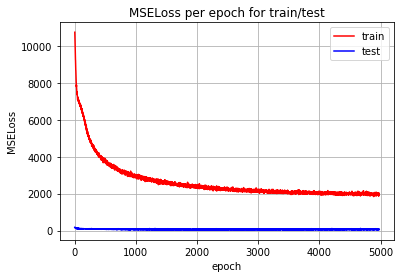

(VAE(
   (fc1): Linear(in_features=100, out_features=66, bias=True)
   (fc21): Linear(in_features=66, out_features=25, bias=True)
   (fc22): Linear(in_features=66, out_features=25, bias=True)
   (fc3): Linear(in_features=25, out_features=66, bias=True)
   (fc4): Linear(in_features=66, out_features=100, bias=True)
 ), tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  1.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  1.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  1.,  0.],
          ...,
          [ 0.,  1.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  

In [629]:
# тест c VAE моделькой
SPD.run_test_vae_mutag(10, n_iterations=5000)

Reading graphs ...
---:  mutag_1.graphml
---:  mutag_2.graphml
---:  mutag_3.graphml
---:  mutag_4.graphml
---:  mutag_5.graphml
---:  mutag_6.graphml
---:  mutag_7.graphml
---:  mutag_8.graphml
---:  mutag_9.graphml
---:  mutag_10.graphml
---:  mutag_11.graphml
---:  mutag_12.graphml
---:  mutag_13.graphml
---:  mutag_14.graphml
---:  mutag_15.graphml
---:  mutag_16.graphml
---:  mutag_17.graphml
---:  mutag_18.graphml
---:  mutag_19.graphml
---:  mutag_20.graphml
---:  mutag_21.graphml
---:  mutag_22.graphml
---:  mutag_23.graphml
---:  mutag_24.graphml
---:  mutag_25.graphml
---:  mutag_26.graphml
---:  mutag_27.graphml
---:  mutag_28.graphml
---:  mutag_29.graphml
---:  mutag_30.graphml
---:  mutag_31.graphml
---:  mutag_32.graphml
---:  mutag_33.graphml
---:  mutag_34.graphml
---:  mutag_35.graphml
---:  mutag_36.graphml
---:  mutag_37.graphml
---:  mutag_38.graphml
---:  mutag_39.graphml
---:  mutag_40.graphml
---:  mutag_41.graphml
---:  mutag_42.graphml
---:  mutag_43.graphml
-

  0%|          | 0/199 [00:00<?, ?it/s]/Users/Macbook/Desktop/MIPT/Optimization_course/SPD_reduce/SPD.py:317: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  loss_data.append((loss_train.data[0], float(loss_test.data[0])))
  5%|▍         | 9/199 [00:00<00:08, 22.51it/s]/Users/Macbook/Desktop/MIPT/Optimization_course/SPD_reduce/SPD.py:312: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  print("EPOCH: {0}, TRAIN LOSS: {1}, TEST LOSS".format(epoch, loss_train.data[0]), float(loss_test.data[0]))
  6%|▌         | 12/199 [00:00<00:08, 22.28it/s]

---:  mutag_148.graphml
---:  mutag_149.graphml
---:  mutag_150.graphml
---:  mutag_151.graphml
---:  mutag_152.graphml
---:  mutag_153.graphml
---:  mutag_154.graphml
---:  mutag_155.graphml
---:  mutag_156.graphml
---:  mutag_157.graphml
---:  mutag_158.graphml
---:  mutag_159.graphml
---:  mutag_160.graphml
---:  mutag_161.graphml
---:  mutag_162.graphml
---:  mutag_163.graphml
---:  mutag_164.graphml
---:  mutag_165.graphml
---:  mutag_166.graphml
---:  mutag_167.graphml
---:  mutag_168.graphml
---:  mutag_169.graphml
---:  mutag_170.graphml
---:  mutag_171.graphml
---:  mutag_172.graphml
---:  mutag_173.graphml
---:  mutag_174.graphml
---:  mutag_175.graphml
---:  mutag_176.graphml
---:  mutag_177.graphml
---:  mutag_178.graphml
---:  mutag_179.graphml
---:  mutag_180.graphml
---:  mutag_181.graphml
---:  mutag_182.graphml
---:  mutag_183.graphml
---:  mutag_184.graphml
---:  mutag_185.graphml
---:  mutag_186.graphml
---:  mutag_187.graphml
---:  mutag_188.graphml
EPOCH: 10, TRAIN

 12%|█▏        | 23/199 [00:01<00:08, 21.76it/s]

EPOCH: 20, TRAIN LOSS: 0.14611342549324036, TEST LOSS 0.14572131633758545


 16%|█▌        | 32/199 [00:01<00:07, 21.70it/s]

EPOCH: 30, TRAIN LOSS: 0.13143573701381683, TEST LOSS 0.13874071836471558


 22%|██▏       | 44/199 [00:02<00:07, 19.87it/s]

EPOCH: 40, TRAIN LOSS: 0.12582707405090332, TEST LOSS 0.12487766891717911


 26%|██▌       | 52/199 [00:02<00:07, 20.04it/s]

EPOCH: 50, TRAIN LOSS: 0.12440881878137589, TEST LOSS 0.12449484318494797


 31%|███       | 62/199 [00:03<00:07, 19.27it/s]

EPOCH: 60, TRAIN LOSS: 0.12250521779060364, TEST LOSS 0.12260595709085464


 37%|███▋      | 73/199 [00:03<00:06, 19.48it/s]

EPOCH: 70, TRAIN LOSS: 0.12054916471242905, TEST LOSS 0.12064839899539948


 42%|████▏     | 83/199 [00:04<00:05, 19.40it/s]

EPOCH: 80, TRAIN LOSS: 0.12023970484733582, TEST LOSS 0.12040434777736664


 47%|████▋     | 93/199 [00:04<00:05, 19.20it/s]

EPOCH: 90, TRAIN LOSS: 0.11967432498931885, TEST LOSS 0.11981910467147827


 51%|█████     | 101/199 [00:05<00:05, 19.05it/s]

EPOCH: 100, TRAIN LOSS: 0.11915827542543411, TEST LOSS 0.11912261694669724


 57%|█████▋    | 113/199 [00:05<00:04, 19.02it/s]

EPOCH: 110, TRAIN LOSS: 0.11862742900848389, TEST LOSS 0.11916164308786392


 62%|██████▏   | 123/199 [00:06<00:03, 19.12it/s]

EPOCH: 120, TRAIN LOSS: 0.11836675554513931, TEST LOSS 0.1192394271492958


 66%|██████▋   | 132/199 [00:06<00:03, 19.24it/s]

EPOCH: 130, TRAIN LOSS: 0.11813563108444214, TEST LOSS 0.11918319016695023


 72%|███████▏  | 144/199 [00:07<00:02, 19.42it/s]

EPOCH: 140, TRAIN LOSS: 0.11795154213905334, TEST LOSS 0.11920249462127686


 77%|███████▋  | 153/199 [00:07<00:02, 19.38it/s]

EPOCH: 150, TRAIN LOSS: 0.11750530451536179, TEST LOSS 0.11928265541791916


 81%|████████  | 161/199 [00:08<00:01, 19.42it/s]

EPOCH: 160, TRAIN LOSS: 0.11699243634939194, TEST LOSS 0.1189749464392662


 86%|████████▋ | 172/199 [00:08<00:01, 19.35it/s]

EPOCH: 170, TRAIN LOSS: 0.11672215908765793, TEST LOSS 0.11859949678182602


 92%|█████████▏| 184/199 [00:09<00:00, 19.45it/s]

EPOCH: 180, TRAIN LOSS: 0.1164478287100792, TEST LOSS 0.11834581196308136


 97%|█████████▋| 193/199 [00:09<00:00, 19.51it/s]

EPOCH: 190, TRAIN LOSS: 0.11623617261648178, TEST LOSS 0.1183684766292572


100%|██████████| 199/199 [00:10<00:00, 19.46it/s]


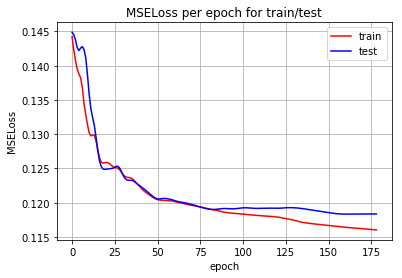

(MatrixEncoder(
   (encoder): Sequential(
     (0): Linear2D()
     (1): Tanh()
   )
   (decoder): Sequential(
     (0): Linear2D()
     (1): ReLU()
   )
 ), tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  1.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  1.,  0.,  ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  1.,  ...,  0.,  1.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  1.],
          [ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  1.,  0.,  0.]],
 
         [[ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.

In [661]:
# еще один тест с блоками из статьи, но с другими параметрами
SPD.run_test_mutag(10, 200)

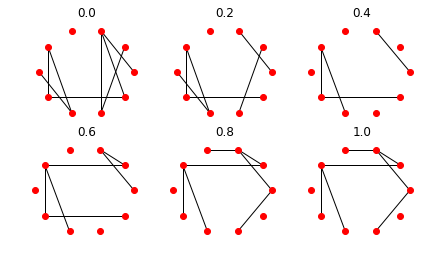

In [684]:
n_points = 6
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(7, 4))
cmap = sns.cubehelix_palette(as_cmap=True)
for i, t in enumerate(np.linspace(0, 1, n_points)):
    C_t = A - (A-B)*t
    GC_t = coder.decoder(C_t).round()
    dt.draw_graph(GC_t, ax=axes[i//3, i%3], node_color='r')
    axes[i//3, i%3].set_title(round(t, 2))
    axes[i//3, i%3].plot()
fig.savefig('homotopy.pdf', format='pdf')

Здесь попробуем порешать задачу классификации на датасете mutag

In [534]:
# создаем сам датасет
X, y = dt.build_dataset(dt.read_test_graphs(), 10)

Reading graphs ...
---:  mutag_1.graphml
---:  mutag_2.graphml
---:  mutag_3.graphml
---:  mutag_4.graphml
---:  mutag_5.graphml
---:  mutag_6.graphml
---:  mutag_7.graphml
---:  mutag_8.graphml
---:  mutag_9.graphml
---:  mutag_10.graphml
---:  mutag_11.graphml
---:  mutag_12.graphml
---:  mutag_13.graphml
---:  mutag_14.graphml
---:  mutag_15.graphml
---:  mutag_16.graphml
---:  mutag_17.graphml
---:  mutag_18.graphml
---:  mutag_19.graphml
---:  mutag_20.graphml
---:  mutag_21.graphml
---:  mutag_22.graphml
---:  mutag_23.graphml
---:  mutag_24.graphml
---:  mutag_25.graphml
---:  mutag_26.graphml
---:  mutag_27.graphml
---:  mutag_28.graphml
---:  mutag_29.graphml
---:  mutag_30.graphml
---:  mutag_31.graphml
---:  mutag_32.graphml
---:  mutag_33.graphml
---:  mutag_34.graphml
---:  mutag_35.graphml
---:  mutag_36.graphml
---:  mutag_37.graphml
---:  mutag_38.graphml
---:  mutag_39.graphml
---:  mutag_40.graphml
---:  mutag_41.graphml
---:  mutag_42.graphml
---:  mutag_43.graphml
-

In [549]:
# строим эмбеддинги для графов 
temp = np.array([coder.encoder(x.unsqueeze(0)).view(-1,).data.numpy() for x in X])

In [577]:
# пробуем визуализировать датасет
tsne = TSNE(n_components=2)
q = tsne.fit_transform(temp)

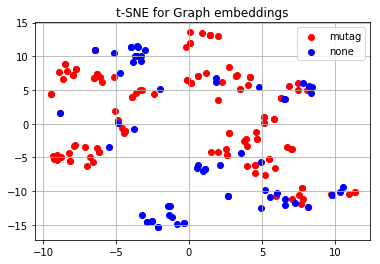

In [562]:
# отрисовываем все это дело
plt.scatter(q[np.where(y == 0)][:, 0], q[np.where(y == 0)][:, 1], c='r', label='mutag')
plt.scatter(q[np.where(y == 1)][:, 0], q[np.where(y == 1)][:, 1], c='b', label='none')
plt.title("t-SNE for Graph embeddings")
plt.grid()
plt.legend()
plt.show()

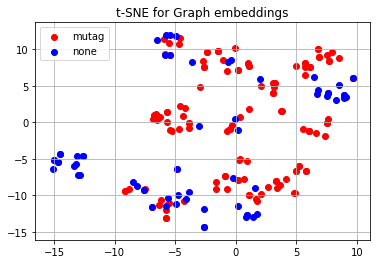

In [659]:
# и еще раз
fig = plt.figure()
plt.scatter(q[np.where(y == 0)][:, 0], q[np.where(y == 0)][:, 1], c='r', label='mutag')
plt.scatter(q[np.where(y == 1)][:, 0], q[np.where(y == 1)][:, 1], c='b', label='none')
plt.title("t-SNE for Graph embeddings")
plt.grid()
plt.legend()
plt.show()
fig.savefig('t-sne.pdf', format='pdf')

In [639]:
# ищем какие-нибудь параметры, которые могут подойти для модели

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV

cls = SVC()
X_train, X_test, y_train, y_test = train_test_split(temp, 
                                                    y, stratify=y, train_size=0.7)

srch = RandomizedSearchCV(cls, {'C': np.linspace(0.01, 10, 40), 
                                'kernel': ('linear', 'rbf'),
                                'gamma': np.linspace(0.01, 10, 50)}, 
                          verbose=True, 
                          scoring='accuracy', 
                          n_iter=30)

srch.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/Macbook/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.3s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=30, n_jobs=1,
          param_distributions={'kernel': ('linear', 'rbf'), 'C': array([  0.01   ,   0.26615,   0.52231,   0.77846,   1.03462,   1.29077,
         1.54692,   1.80308,   2.05923,   2.31538,   2.57154,   2.82769,
         3.08385,   3.34   ,   3.59615,   3.85231,   4.10846,   4.36462,
         4.62077,   4.8769...      8.57286,   8.77673,   8.98061,   9.18449,   9.38837,   9.59224,
         9.79612,  10.     ])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=True)

In [640]:
# смотрим на качество по валидации
cls = SVC(**srch.best_params_)
cv=KFold(n_splits=8, shuffle=True)
res = cross_val_score(cls, temp, y, scoring='accuracy', cv=cv)
print('mean: ', res.mean())
print('std: ', res.std())

mean:  0.797554347826
std:  0.0849749208557


In [657]:
# смотрим на качество по отложенной
indexes =list(range(len(y)))
shuffle(indexes)
size = 50
cls.fit(temp[indexes][:-size], y[indexes][:-size])
print(classification_report(y[indexes][-size:], cls.predict(temp[indexes][-size:])))

             precision    recall  f1-score   support

          0       0.82      0.91      0.86        34
          1       0.75      0.56      0.64        16

avg / total       0.79      0.80      0.79        50

